In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/models/epoch_40.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/data/test_data_protocol_4.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/models/epoch_40.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 20))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

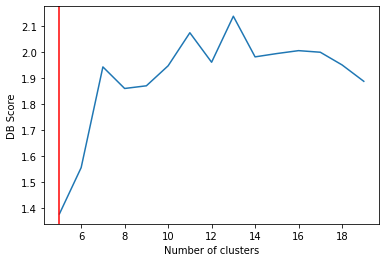

{0, 1, 2, 3, 4}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

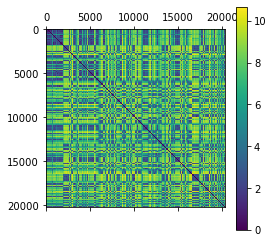

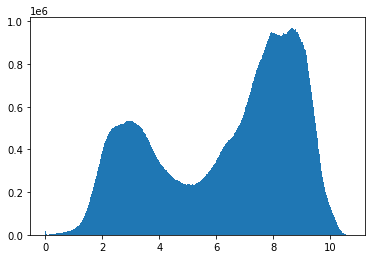

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

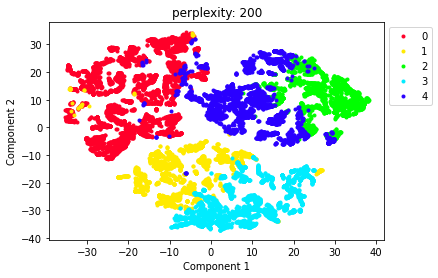

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 12

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9908835559059774


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.0784881171621503
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.8344267955801106
layer 6: 0.6335462707182321
layer 7: 0.3631301795580111
layer 8: 0.18929126381215472
layer 9: 0.09271408839779006
layer 10: 0.04442550069060773
Epoch: 00 | Batch: 000 / 011 | Total loss: 1.620 | Reg loss: 0.021 | Tree loss: 1.620 | Accuracy: 0.307000 | 17.715 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 1.605 | Reg loss: 0.021 | Tree loss: 1.605 | Accuracy: 0.239500 | 13.289 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 1.588 | Reg loss: 0.020 | Tree loss: 1.588 | Accuracy: 0.241000 | 12.705 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 1.575 | Reg loss: 0.020 | Tree loss: 1.575 | Accuracy: 0.366000 | 11.789 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 1.555 | Reg loss: 0.019 | Tree loss: 1.555 | Accuracy: 0.409500 | 11.666 sec/iter
Epoch: 00 | Batch: 005 / 011 

Epoch: 04 | Batch: 008 / 011 | Total loss: 1.492 | Reg loss: 0.017 | Tree loss: 1.492 | Accuracy: 0.391000 | 10.498 sec/iter
Epoch: 04 | Batch: 009 / 011 | Total loss: 1.472 | Reg loss: 0.017 | Tree loss: 1.472 | Accuracy: 0.415000 | 10.481 sec/iter
Epoch: 04 | Batch: 010 / 011 | Total loss: 1.454 | Reg loss: 0.017 | Tree loss: 1.454 | Accuracy: 0.430034 | 10.371 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 1.579 | Reg loss: 0.016 | Tree loss: 1.579 | Accuracy: 0.344500 | 10.69 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 1.569 | Reg loss: 0.016 | Tree loss: 1.569 | Accuracy: 0.323500 | 10.682 sec/iter
Epoch: 05 | Batch: 002 / 011

Epoch: 09 | Batch: 005 / 011 | Total loss: 1.438 | Reg loss: 0.016 | Tree loss: 1.438 | Accuracy: 0.463000 | 10.598 sec/iter
Epoch: 09 | Batch: 006 / 011 | Total loss: 1.415 | Reg loss: 0.017 | Tree loss: 1.415 | Accuracy: 0.480000 | 10.575 sec/iter
Epoch: 09 | Batch: 007 / 011 | Total loss: 1.406 | Reg loss: 0.017 | Tree loss: 1.406 | Accuracy: 0.467500 | 10.558 sec/iter
Epoch: 09 | Batch: 008 / 011 | Total loss: 1.386 | Reg loss: 0.017 | Tree loss: 1.386 | Accuracy: 0.471500 | 10.561 sec/iter
Epoch: 09 | Batch: 009 / 011 | Total loss: 1.406 | Reg loss: 0.017 | Tree loss: 1.406 | Accuracy: 0.414500 | 10.552 sec/iter
Epoch: 09 | Batch: 010 / 011 | Total loss: 1.405 | Reg loss: 0.017 | Tree loss: 1.405 | Accuracy: 0.385666 | 10.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 14 | Batch: 002 / 011 | Total loss: 1.434 | Reg loss: 0.017 | Tree loss: 1.434 | Accuracy: 0.392000 | 10.576 sec/iter
Epoch: 14 | Batch: 003 / 011 | Total loss: 1.410 | Reg loss: 0.017 | Tree loss: 1.410 | Accuracy: 0.376500 | 10.563 sec/iter
Epoch: 14 | Batch: 004 / 011 | Total loss: 1.374 | Reg loss: 0.017 | Tree loss: 1.374 | Accuracy: 0.393000 | 10.55 sec/iter
Epoch: 14 | Batch: 005 / 011 | Total loss: 1.353 | Reg loss: 0.017 | Tree loss: 1.353 | Accuracy: 0.408000 | 10.522 sec/iter
Epoch: 14 | Batch: 006 / 011 | Total loss: 1.341 | Reg loss: 0.018 | Tree loss: 1.341 | Accuracy: 0.397500 | 10.499 sec/iter
Epoch: 14 | Batch: 007 / 011 | Total loss: 1.326 | Reg loss: 0.018 | Tree loss: 1.326 | Accuracy: 0.414000 | 10.483 sec/iter
Epoch: 14 | Batch: 008 / 011 | Total loss: 1.308 | Reg loss: 0.018 | Tree loss: 1.308 | Accuracy: 0.422000 | 10.468 sec/iter
Epoch: 14 | Batch: 009 / 011 | Total loss: 1.279 | Reg loss: 0.018 | Tree loss: 1.279 | Accuracy: 0.464500 | 10.452 sec/iter
E

Epoch: 19 | Batch: 000 / 011 | Total loss: 1.394 | Reg loss: 0.019 | Tree loss: 1.394 | Accuracy: 0.430000 | 9.964 sec/iter
Epoch: 19 | Batch: 001 / 011 | Total loss: 1.353 | Reg loss: 0.019 | Tree loss: 1.353 | Accuracy: 0.472000 | 9.956 sec/iter
Epoch: 19 | Batch: 002 / 011 | Total loss: 1.327 | Reg loss: 0.019 | Tree loss: 1.327 | Accuracy: 0.490500 | 9.947 sec/iter
Epoch: 19 | Batch: 003 / 011 | Total loss: 1.289 | Reg loss: 0.019 | Tree loss: 1.289 | Accuracy: 0.495000 | 9.937 sec/iter
Epoch: 19 | Batch: 004 / 011 | Total loss: 1.279 | Reg loss: 0.019 | Tree loss: 1.279 | Accuracy: 0.492500 | 9.929 sec/iter
Epoch: 19 | Batch: 005 / 011 | Total loss: 1.245 | Reg loss: 0.019 | Tree loss: 1.245 | Accuracy: 0.513500 | 9.91 sec/iter
Epoch: 19 | Batch: 006 / 011 | Total loss: 1.222 | Reg loss: 0.019 | Tree loss: 1.222 | Accuracy: 0.523000 | 9.903 sec/iter
Epoch: 19 | Batch: 007 / 011 | Total loss: 1.214 | Reg loss: 0.019 | Tree loss: 1.214 | Accuracy: 0.550500 | 9.896 sec/iter
Epoch: 19

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 24 | Batch: 000 / 011 | Total loss: 1.306 | Reg loss: 0.020 | Tree loss: 1.306 | Accuracy: 0.514000 | 9.574 sec/iter
Epoch: 24 | Batch: 001 / 011 | Total loss: 1.251 | Reg loss: 0.020 | Tree loss: 1.251 | Accuracy: 0.543000 | 9.569 sec/iter
Epoch: 24 | Batch: 002 / 011 | Total loss: 1.227 | Reg loss: 0.021 | Tree loss: 1.227 | Accuracy: 0.548500 | 9.564 sec/iter
Epoch: 24 | Batch: 003 / 011 | Total loss: 1.220 | Reg loss: 0.021 | Tree loss: 1.220 | Accuracy: 0.548500 | 9.558 sec/iter
Epoch: 24 | Batch: 004 / 011 | Total loss: 1.190 | Reg loss: 0.021 | Tree loss: 1.190 | Accuracy: 0.538000 | 9.552 sec/iter
Epoch: 24 | Batch: 005 / 011 | T

Epoch: 28 | Batch: 009 / 011 | Total loss: 1.080 | Reg loss: 0.022 | Tree loss: 1.080 | Accuracy: 0.576000 | 9.342 sec/iter
Epoch: 28 | Batch: 010 / 011 | Total loss: 1.021 | Reg loss: 0.022 | Tree loss: 1.021 | Accuracy: 0.607509 | 9.326 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 29 | Batch: 000 / 011 | Total loss: 1.217 | Reg loss: 0.022 | Tree loss: 1.217 | Accuracy: 0.557500 | 9.381 sec/iter
Epoch: 29 | Batch: 001 / 011 | Total loss: 1.190 | Reg loss: 0.022 | Tree loss: 1.190 | Accuracy: 0.590500 | 9.378 sec/iter
Epoch: 29 | Batch: 002 / 011 | Total loss: 1.170 | Reg loss: 0.022 | Tree loss: 1.170 | Accuracy: 0.579500 | 9.383 sec/iter
Epoch: 29 | Batch: 003 / 011 | T

Epoch: 33 | Batch: 007 / 011 | Total loss: 1.026 | Reg loss: 0.023 | Tree loss: 1.026 | Accuracy: 0.598500 | 9.511 sec/iter
Epoch: 33 | Batch: 008 / 011 | Total loss: 1.024 | Reg loss: 0.023 | Tree loss: 1.024 | Accuracy: 0.582000 | 9.516 sec/iter
Epoch: 33 | Batch: 009 / 011 | Total loss: 0.991 | Reg loss: 0.023 | Tree loss: 0.991 | Accuracy: 0.595500 | 9.517 sec/iter
Epoch: 33 | Batch: 010 / 011 | Total loss: 1.004 | Reg loss: 0.023 | Tree loss: 1.004 | Accuracy: 0.593857 | 9.502 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 34 | Batch: 000 / 011 | Total loss: 1.125 | Reg loss: 0.023 | Tree loss: 1.125 | Accuracy: 0.600500 | 9.554 sec/iter
Epoch: 34 | Batch: 001 / 011 | T

Epoch: 38 | Batch: 005 / 011 | Total loss: 1.017 | Reg loss: 0.023 | Tree loss: 1.017 | Accuracy: 0.607500 | 9.661 sec/iter
Epoch: 38 | Batch: 006 / 011 | Total loss: 0.967 | Reg loss: 0.023 | Tree loss: 0.967 | Accuracy: 0.626000 | 9.654 sec/iter
Epoch: 38 | Batch: 007 / 011 | Total loss: 0.969 | Reg loss: 0.023 | Tree loss: 0.969 | Accuracy: 0.606000 | 9.658 sec/iter
Epoch: 38 | Batch: 008 / 011 | Total loss: 0.964 | Reg loss: 0.023 | Tree loss: 0.964 | Accuracy: 0.599000 | 9.659 sec/iter
Epoch: 38 | Batch: 009 / 011 | Total loss: 0.952 | Reg loss: 0.023 | Tree loss: 0.952 | Accuracy: 0.604000 | 9.664 sec/iter
Epoch: 38 | Batch: 010 / 011 | Total loss: 0.946 | Reg loss: 0.023 | Tree loss: 0.946 | Accuracy: 0.614334 | 9.65 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237569060

Epoch: 43 | Batch: 003 / 011 | Total loss: 0.993 | Reg loss: 0.023 | Tree loss: 0.993 | Accuracy: 0.619500 | 9.785 sec/iter
Epoch: 43 | Batch: 004 / 011 | Total loss: 0.990 | Reg loss: 0.023 | Tree loss: 0.990 | Accuracy: 0.621500 | 9.781 sec/iter
Epoch: 43 | Batch: 005 / 011 | Total loss: 0.961 | Reg loss: 0.023 | Tree loss: 0.961 | Accuracy: 0.619500 | 9.775 sec/iter
Epoch: 43 | Batch: 006 / 011 | Total loss: 0.945 | Reg loss: 0.023 | Tree loss: 0.945 | Accuracy: 0.624500 | 9.77 sec/iter
Epoch: 43 | Batch: 007 / 011 | Total loss: 0.944 | Reg loss: 0.023 | Tree loss: 0.944 | Accuracy: 0.608000 | 9.77 sec/iter
Epoch: 43 | Batch: 008 / 011 | Total loss: 0.955 | Reg loss: 0.023 | Tree loss: 0.955 | Accuracy: 0.573500 | 9.774 sec/iter
Epoch: 43 | Batch: 009 / 011 | Total loss: 0.929 | Reg loss: 0.023 | Tree loss: 0.929 | Accuracy: 0.595000 | 9.773 sec/iter
Epoch: 43 | Batch: 010 / 011 | Total loss: 0.938 | Reg loss: 0.023 | Tree loss: 0.938 | Accuracy: 0.569966 | 9.761 sec/iter
Average sp

Epoch: 48 | Batch: 001 / 011 | Total loss: 1.009 | Reg loss: 0.023 | Tree loss: 1.009 | Accuracy: 0.604000 | 9.873 sec/iter
Epoch: 48 | Batch: 002 / 011 | Total loss: 0.996 | Reg loss: 0.023 | Tree loss: 0.996 | Accuracy: 0.608500 | 9.874 sec/iter
Epoch: 48 | Batch: 003 / 011 | Total loss: 0.990 | Reg loss: 0.023 | Tree loss: 0.990 | Accuracy: 0.605500 | 9.87 sec/iter
Epoch: 48 | Batch: 004 / 011 | Total loss: 0.966 | Reg loss: 0.023 | Tree loss: 0.966 | Accuracy: 0.600500 | 9.866 sec/iter
Epoch: 48 | Batch: 005 / 011 | Total loss: 0.940 | Reg loss: 0.023 | Tree loss: 0.940 | Accuracy: 0.627500 | 9.86 sec/iter
Epoch: 48 | Batch: 006 / 011 | Total loss: 0.923 | Reg loss: 0.023 | Tree loss: 0.923 | Accuracy: 0.617500 | 9.856 sec/iter
Epoch: 48 | Batch: 007 / 011 | Total loss: 0.913 | Reg loss: 0.024 | Tree loss: 0.913 | Accuracy: 0.614000 | 9.856 sec/iter
Epoch: 48 | Batch: 008 / 011 | Total loss: 0.927 | Reg loss: 0.024 | Tree loss: 0.927 | Accuracy: 0.605000 | 9.859 sec/iter
Epoch: 48 

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 53 | Batch: 000 / 011 | Total loss: 1.020 | Reg loss: 0.024 | Tree loss: 1.020 | Accuracy: 0.594000 | 9.934 sec/iter
Epoch: 53 | Batch: 001 / 011 | Total loss: 1.003 | Reg loss: 0.024 | Tree loss: 1.003 | Accuracy: 0.588500 | 9.932 sec/iter
Epoch: 53 | Batch: 002 / 011 | Total loss: 0.984 | Reg loss: 0.024 | Tree loss: 0.984 | Accuracy: 0.611000 | 9.935 sec/iter
Epoch: 53 | Batch: 003 / 011 | Total loss: 0.959 | Reg loss: 0.024 | Tree loss: 0.959 | Accuracy: 0.603000 | 9.934 sec/iter
Epoch: 53 | Batch: 004 / 011 | Total loss: 0.961 | Reg loss: 0.024 | Tree loss: 0.961 | Accuracy: 0.600000 | 9.93 sec/iter
Epoch: 53 | Batch: 005 / 011 | Total loss: 0.904 | Reg loss: 0.024 | Tree loss: 0.904 | Accuracy: 0.634000 | 9.925 sec/iter
Epoch: 53 | Batch: 006 / 011 | Total loss: 0.906 | Reg loss: 0.024 | Tree loss: 0.906 | Accuracy: 0.628500 | 9.921 sec/iter
Epoch: 53 | Batch: 007 / 011 | Total loss: 0.913

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 58 | Batch: 000 / 011 | Total loss: 1.008 | Reg loss: 0.024 | Tree loss: 1.008 | Accuracy: 0.587000 | 9.99 sec/iter
Epoch: 58 | Batch: 001 / 011 | Total loss: 0.974 | Reg loss: 0.024 | Tree loss: 0.974 | Accuracy: 0.614000 | 9.991 sec/iter
Epoch: 58 | Batch: 002 / 011 | Total loss: 0.970 | Reg loss: 0.024 | Tree loss: 0.970 | Accuracy: 0.616500 | 9.99 sec/iter
Epoch: 58 | Batch: 003 / 011 | Total loss: 0.931 | Reg loss: 0.024 | Tree loss: 0.931 | Accuracy: 0.631500 | 9.991 sec/iter
Epoch: 58 | Batch: 004 / 011 | Total loss: 0.946 | Reg loss: 0.024 | Tree loss: 0.946 | Accuracy: 0.605500 | 9.986 sec/iter
Epoch: 58 | Batch: 005 / 011 | Tot

Epoch: 62 | Batch: 008 / 011 | Total loss: 0.880 | Reg loss: 0.024 | Tree loss: 0.880 | Accuracy: 0.587500 | 10.014 sec/iter
Epoch: 62 | Batch: 009 / 011 | Total loss: 0.876 | Reg loss: 0.024 | Tree loss: 0.876 | Accuracy: 0.594500 | 10.014 sec/iter
Epoch: 62 | Batch: 010 / 011 | Total loss: 0.872 | Reg loss: 0.024 | Tree loss: 0.872 | Accuracy: 0.604096 | 10.005 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 63 | Batch: 000 / 011 | Total loss: 0.970 | Reg loss: 0.024 | Tree loss: 0.970 | Accuracy: 0.598500 | 10.034 sec/iter
Epoch: 63 | Batch: 001 / 011 | Total loss: 0.977 | Reg loss: 0.024 | Tree loss: 0.977 | Accuracy: 0.588000 | 10.032 sec/iter
Epoch: 63 | Batch: 002 / 01

Epoch: 67 | Batch: 005 / 011 | Total loss: 0.883 | Reg loss: 0.024 | Tree loss: 0.883 | Accuracy: 0.641000 | 10.05 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 0.896 | Reg loss: 0.024 | Tree loss: 0.896 | Accuracy: 0.610000 | 10.045 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 0.860 | Reg loss: 0.024 | Tree loss: 0.860 | Accuracy: 0.609000 | 10.047 sec/iter
Epoch: 67 | Batch: 008 / 011 | Total loss: 0.873 | Reg loss: 0.024 | Tree loss: 0.873 | Accuracy: 0.587000 | 10.046 sec/iter
Epoch: 67 | Batch: 009 / 011 | Total loss: 0.873 | Reg loss: 0.024 | Tree loss: 0.873 | Accuracy: 0.583000 | 10.048 sec/iter
Epoch: 67 | Batch: 010 / 011 | Total loss: 0.826 | Reg loss: 0.024 | Tree loss: 0.826 | Accuracy: 0.645051 | 10.039 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 72 | Batch: 002 / 011 | Total loss: 0.934 | Reg loss: 0.024 | Tree loss: 0.934 | Accuracy: 0.612000 | 10.089 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 0.887 | Reg loss: 0.024 | Tree loss: 0.887 | Accuracy: 0.631000 | 10.088 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 0.901 | Reg loss: 0.024 | Tree loss: 0.901 | Accuracy: 0.633000 | 10.085 sec/iter
Epoch: 72 | Batch: 005 / 011 | Total loss: 0.903 | Reg loss: 0.024 | Tree loss: 0.903 | Accuracy: 0.618500 | 10.081 sec/iter
Epoch: 72 | Batch: 006 / 011 | Total loss: 0.860 | Reg loss: 0.024 | Tree loss: 0.860 | Accuracy: 0.620500 | 10.078 sec/iter
Epoch: 72 | Batch: 007 / 011 | Total loss: 0.858 | Reg loss: 0.024 | Tree loss: 0.858 | Accuracy: 0.610000 | 10.08 sec/iter
Epoch: 72 | Batch: 008 / 011 | Total loss: 0.878 | Reg loss: 0.024 | Tree loss: 0.878 | Accuracy: 0.593500 | 10.079 sec/iter
Epoch: 72 | Batch: 009 / 011 | Total loss: 0.886 | Reg loss: 0.024 | Tree loss: 0.886 | Accuracy: 0.571000 | 10.081 sec/iter
E

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 77 | Batch: 000 / 011 | Total loss: 0.935 | Reg loss: 0.024 | Tree loss: 0.935 | Accuracy: 0.614000 | 10.122 sec/iter
Epoch: 77 | Batch: 001 / 011 | Total loss: 0.920 | Reg loss: 0.024 | Tree loss: 0.920 | Accuracy: 0.621000 | 10.123 sec/iter
Epoch: 77 | Batch: 002 / 011 | Total loss: 0.933 | Reg loss: 0.024 | Tree loss: 0.933 | Accuracy: 0.602500 | 10.122 sec/iter
Epoch: 77 | Batch: 003 / 011 | Total loss: 0.922 | Reg loss: 0.024 | Tree loss: 0.922 | Accuracy: 0.617500 | 10.12 sec/iter
Epoch: 77 | Batch: 004 / 011 | Total loss: 0.884 | Reg loss: 0.024 | Tree loss: 0.884 | Accuracy: 0.629000 | 10.116 sec/iter
Epoch: 77 | Batch: 005 / 011 | Total loss: 0.879 | Reg loss: 0.024 | Tree loss: 0.879 | Accuracy: 0.641500 | 10.112 sec/iter
Epoch: 77 | Batch: 006 / 011 | Total loss: 0.889 | Reg loss: 0.024 | Tree loss: 0.889 | Accuracy: 0.600000 | 1

Epoch: 81 | Batch: 010 / 011 | Total loss: 0.911 | Reg loss: 0.024 | Tree loss: 0.911 | Accuracy: 0.569966 | 10.12 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 82 | Batch: 000 / 011 | Total loss: 0.939 | Reg loss: 0.024 | Tree loss: 0.939 | Accuracy: 0.613500 | 10.139 sec/iter
Epoch: 82 | Batch: 001 / 011 | Total loss: 0.946 | Reg loss: 0.024 | Tree loss: 0.946 | Accuracy: 0.584500 | 10.137 sec/iter
Epoch: 82 | Batch: 002 / 011 | Total loss: 0.920 | Reg loss: 0.024 | Tree loss: 0.920 | Accuracy: 0.607000 | 10.139 sec/iter
Epoch: 82 | Batch: 003 / 011 | Total loss: 0.914 | Reg loss: 0.024 | Tree loss: 0.914 | Accuracy: 0.621500 | 10.137 sec/iter
Epoch: 82 | Batch: 004 / 011

Epoch: 86 | Batch: 007 / 011 | Total loss: 0.859 | Reg loss: 0.024 | Tree loss: 0.859 | Accuracy: 0.613500 | 10.139 sec/iter
Epoch: 86 | Batch: 008 / 011 | Total loss: 0.843 | Reg loss: 0.024 | Tree loss: 0.843 | Accuracy: 0.601000 | 10.139 sec/iter
Epoch: 86 | Batch: 009 / 011 | Total loss: 0.871 | Reg loss: 0.024 | Tree loss: 0.871 | Accuracy: 0.571000 | 10.14 sec/iter
Epoch: 86 | Batch: 010 / 011 | Total loss: 0.883 | Reg loss: 0.024 | Tree loss: 0.883 | Accuracy: 0.569966 | 10.134 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 87 | Batch: 000 / 011 | Total loss: 0.959 | Reg loss: 0.024 | Tree loss: 0.959 | Accuracy: 0.580500 | 10.154 sec/iter
Epoch: 87 | Batch: 001 / 011

Epoch: 91 | Batch: 004 / 011 | Total loss: 0.881 | Reg loss: 0.024 | Tree loss: 0.881 | Accuracy: 0.639000 | 10.17 sec/iter
Epoch: 91 | Batch: 005 / 011 | Total loss: 0.885 | Reg loss: 0.024 | Tree loss: 0.885 | Accuracy: 0.611500 | 10.167 sec/iter
Epoch: 91 | Batch: 006 / 011 | Total loss: 0.863 | Reg loss: 0.024 | Tree loss: 0.863 | Accuracy: 0.619500 | 10.164 sec/iter
Epoch: 91 | Batch: 007 / 011 | Total loss: 0.839 | Reg loss: 0.024 | Tree loss: 0.839 | Accuracy: 0.621500 | 10.164 sec/iter
Epoch: 91 | Batch: 008 / 011 | Total loss: 0.847 | Reg loss: 0.024 | Tree loss: 0.847 | Accuracy: 0.610000 | 10.165 sec/iter
Epoch: 91 | Batch: 009 / 011 | Total loss: 0.862 | Reg loss: 0.024 | Tree loss: 0.862 | Accuracy: 0.592000 | 10.164 sec/iter
Epoch: 91 | Batch: 010 / 011 | Total loss: 0.808 | Reg loss: 0.024 | Tree loss: 0.808 | Accuracy: 0.593857 | 10.158 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
lay

Epoch: 96 | Batch: 001 / 011 | Total loss: 0.907 | Reg loss: 0.024 | Tree loss: 0.907 | Accuracy: 0.602000 | 10.195 sec/iter
Epoch: 96 | Batch: 002 / 011 | Total loss: 0.894 | Reg loss: 0.024 | Tree loss: 0.894 | Accuracy: 0.608000 | 10.194 sec/iter
Epoch: 96 | Batch: 003 / 011 | Total loss: 0.890 | Reg loss: 0.024 | Tree loss: 0.890 | Accuracy: 0.622000 | 10.195 sec/iter
Epoch: 96 | Batch: 004 / 011 | Total loss: 0.885 | Reg loss: 0.024 | Tree loss: 0.885 | Accuracy: 0.637500 | 10.192 sec/iter
Epoch: 96 | Batch: 005 / 011 | Total loss: 0.876 | Reg loss: 0.024 | Tree loss: 0.876 | Accuracy: 0.642000 | 10.189 sec/iter
Epoch: 96 | Batch: 006 / 011 | Total loss: 0.851 | Reg loss: 0.024 | Tree loss: 0.851 | Accuracy: 0.627500 | 10.186 sec/iter
Epoch: 96 | Batch: 007 / 011 | Total loss: 0.869 | Reg loss: 0.024 | Tree loss: 0.869 | Accuracy: 0.588000 | 10.187 sec/iter
Epoch: 96 | Batch: 008 / 011 | Total loss: 0.848 | Reg loss: 0.024 | Tree loss: 0.848 | Accuracy: 0.593500 | 10.186 sec/iter


layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 101 | Batch: 000 / 011 | Total loss: 0.916 | Reg loss: 0.024 | Tree loss: 0.916 | Accuracy: 0.601000 | 10.21 sec/iter
Epoch: 101 | Batch: 001 / 011 | Total loss: 0.908 | Reg loss: 0.024 | Tree loss: 0.908 | Accuracy: 0.594000 | 10.21 sec/iter
Epoch: 101 | Batch: 002 / 011 | Total loss: 0.918 | Reg loss: 0.024 | Tree loss: 0.918 | Accuracy: 0.579000 | 10.21 sec/iter
Epoch: 101 | Batch: 003 / 011 | Total loss: 0.887 | Reg loss: 0.024 | Tree loss: 0.887 | Accuracy: 0.608000 | 10.21 sec/iter
Epoch: 101 | Batch: 004 / 011 | Total loss: 0.880 | Reg loss: 0.024 | Tree loss: 0.880 | Accuracy: 0.630500 | 10.208 sec/iter
Epoch: 101 | Batch: 005 / 011 | Total loss: 0.861 | Reg loss: 0.024 | Tree loss: 0.861 | Accuracy: 0.637000 | 10.205 sec/iter
Epoch: 101 | Batch: 006 / 011 | Total loss: 0.856 | Reg loss: 0.024 | Tree loss: 0.856 | Accuracy: 0.615500

Epoch: 105 | Batch: 009 / 011 | Total loss: 0.842 | Reg loss: 0.024 | Tree loss: 0.842 | Accuracy: 0.601500 | 10.215 sec/iter
Epoch: 105 | Batch: 010 / 011 | Total loss: 0.765 | Reg loss: 0.024 | Tree loss: 0.765 | Accuracy: 0.638225 | 10.209 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 106 | Batch: 000 / 011 | Total loss: 0.918 | Reg loss: 0.024 | Tree loss: 0.918 | Accuracy: 0.596500 | 10.225 sec/iter
Epoch: 106 | Batch: 001 / 011 | Total loss: 0.906 | Reg loss: 0.024 | Tree loss: 0.906 | Accuracy: 0.613500 | 10.224 sec/iter
Epoch: 106 | Batch: 002 / 011 | Total loss: 0.903 | Reg loss: 0.024 | Tree loss: 0.903 | Accuracy: 0.605000 | 10.225 sec/iter
Epoch: 106 | Batch: 00

Epoch: 110 | Batch: 006 / 011 | Total loss: 0.851 | Reg loss: 0.024 | Tree loss: 0.851 | Accuracy: 0.609000 | 10.162 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 0.842 | Reg loss: 0.024 | Tree loss: 0.842 | Accuracy: 0.623500 | 10.16 sec/iter
Epoch: 110 | Batch: 008 / 011 | Total loss: 0.831 | Reg loss: 0.024 | Tree loss: 0.831 | Accuracy: 0.620000 | 10.158 sec/iter
Epoch: 110 | Batch: 009 / 011 | Total loss: 0.857 | Reg loss: 0.024 | Tree loss: 0.857 | Accuracy: 0.597000 | 10.156 sec/iter
Epoch: 110 | Batch: 010 / 011 | Total loss: 0.834 | Reg loss: 0.024 | Tree loss: 0.834 | Accuracy: 0.610922 | 10.151 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 111 | Batch: 000

Epoch: 115 | Batch: 003 / 011 | Total loss: 0.867 | Reg loss: 0.024 | Tree loss: 0.867 | Accuracy: 0.646500 | 10.075 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 0.862 | Reg loss: 0.024 | Tree loss: 0.862 | Accuracy: 0.652000 | 10.074 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 0.858 | Reg loss: 0.024 | Tree loss: 0.858 | Accuracy: 0.651500 | 10.073 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 0.868 | Reg loss: 0.024 | Tree loss: 0.868 | Accuracy: 0.598500 | 10.072 sec/iter
Epoch: 115 | Batch: 007 / 011 | Total loss: 0.856 | Reg loss: 0.024 | Tree loss: 0.856 | Accuracy: 0.593000 | 10.07 sec/iter
Epoch: 115 | Batch: 008 / 011 | Total loss: 0.817 | Reg loss: 0.024 | Tree loss: 0.817 | Accuracy: 0.615500 | 10.068 sec/iter
Epoch: 115 | Batch: 009 / 011 | Total loss: 0.866 | Reg loss: 0.024 | Tree loss: 0.866 | Accuracy: 0.569500 | 10.067 sec/iter
Epoch: 115 | Batch: 010 / 011 | Total loss: 0.841 | Reg loss: 0.024 | Tree loss: 0.841 | Accuracy: 0.580205 | 10.062 se

layer 10: 0.9723756906077345
Epoch: 120 | Batch: 000 / 011 | Total loss: 0.895 | Reg loss: 0.024 | Tree loss: 0.895 | Accuracy: 0.603000 | 9.995 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 0.886 | Reg loss: 0.024 | Tree loss: 0.886 | Accuracy: 0.596500 | 9.994 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 0.907 | Reg loss: 0.024 | Tree loss: 0.907 | Accuracy: 0.607500 | 9.992 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 0.882 | Reg loss: 0.024 | Tree loss: 0.882 | Accuracy: 0.623500 | 9.99 sec/iter
Epoch: 120 | Batch: 004 / 011 | Total loss: 0.859 | Reg loss: 0.024 | Tree loss: 0.859 | Accuracy: 0.640500 | 9.986 sec/iter
Epoch: 120 | Batch: 005 / 011 | Total loss: 0.855 | Reg loss: 0.024 | Tree loss: 0.855 | Accuracy: 0.637000 | 9.985 sec/iter
Epoch: 120 | Batch: 006 / 011 | Total loss: 0.864 | Reg loss: 0.024 | Tree loss: 0.864 | Accuracy: 0.597000 | 9.984 sec/iter
Epoch: 120 | Batch: 007 / 011 | Total loss: 0.860 | Reg loss: 0.024 | Tree loss: 0.860 | Accuracy

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 125 | Batch: 000 / 011 | Total loss: 0.912 | Reg loss: 0.024 | Tree loss: 0.912 | Accuracy: 0.588000 | 9.924 sec/iter
Epoch: 125 | Batch: 001 / 011 | Total loss: 0.900 | Reg loss: 0.024 | Tree loss: 0.900 | Accuracy: 0.602500 | 9.922 sec/iter
Epoch: 125 | Batch: 002 / 011 | Total loss: 0.886 | Reg loss: 0.024 | Tree loss: 0.886 | Accuracy: 0.615500 | 9.919 sec/iter
Epoch: 125 | Batch: 003 / 011 | Total loss: 0.874 | Reg loss: 0.024 | Tree loss: 0.874 | Accuracy: 0.623000 | 9.918 sec/iter
Epoch: 125 | Batch: 004 / 011 | Total loss: 0.872 | Reg loss: 0.024 | Tree loss: 0.872 | Accuracy: 0.615500 | 9.917 sec/iter
Epoch: 125 | Batch: 005 / 0

Epoch: 129 | Batch: 008 / 011 | Total loss: 0.831 | Reg loss: 0.024 | Tree loss: 0.831 | Accuracy: 0.602500 | 9.856 sec/iter
Epoch: 129 | Batch: 009 / 011 | Total loss: 0.846 | Reg loss: 0.024 | Tree loss: 0.846 | Accuracy: 0.592500 | 9.855 sec/iter
Epoch: 129 | Batch: 010 / 011 | Total loss: 0.831 | Reg loss: 0.024 | Tree loss: 0.831 | Accuracy: 0.614334 | 9.851 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 130 | Batch: 000 / 011 | Total loss: 0.918 | Reg loss: 0.024 | Tree loss: 0.918 | Accuracy: 0.596000 | 9.853 sec/iter
Epoch: 130 | Batch: 001 / 011 | Total loss: 0.867 | Reg loss: 0.024 | Tree loss: 0.867 | Accuracy: 0.625500 | 9.851 sec/iter
Epoch: 130 | Batch: 002 / 0

Epoch: 134 | Batch: 005 / 011 | Total loss: 0.816 | Reg loss: 0.024 | Tree loss: 0.816 | Accuracy: 0.654000 | 9.791 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.832 | Reg loss: 0.024 | Tree loss: 0.832 | Accuracy: 0.618000 | 9.79 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.843 | Reg loss: 0.025 | Tree loss: 0.843 | Accuracy: 0.605500 | 9.789 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.868 | Reg loss: 0.025 | Tree loss: 0.868 | Accuracy: 0.582000 | 9.787 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 0.817 | Reg loss: 0.025 | Tree loss: 0.817 | Accuracy: 0.610500 | 9.786 sec/iter
Epoch: 134 | Batch: 010 / 011 | Total loss: 0.859 | Reg loss: 0.025 | Tree loss: 0.859 | Accuracy: 0.624573 | 9.782 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 139 | Batch: 002 / 011 | Total loss: 0.869 | Reg loss: 0.024 | Tree loss: 0.869 | Accuracy: 0.628500 | 9.729 sec/iter
Epoch: 139 | Batch: 003 / 011 | Total loss: 0.876 | Reg loss: 0.024 | Tree loss: 0.876 | Accuracy: 0.609500 | 9.729 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 0.875 | Reg loss: 0.024 | Tree loss: 0.875 | Accuracy: 0.625500 | 9.728 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.839 | Reg loss: 0.024 | Tree loss: 0.839 | Accuracy: 0.643000 | 9.727 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.861 | Reg loss: 0.025 | Tree loss: 0.861 | Accuracy: 0.613500 | 9.727 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 0.869 | Reg loss: 0.025 | Tree loss: 0.869 | Accuracy: 0.598500 | 9.726 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 0.836 | Reg loss: 0.025 | Tree loss: 0.836 | Accuracy: 0.609000 | 9.725 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 0.818 | Reg loss: 0.025 | Tree loss: 0.818 | Accuracy: 0.624000 | 9.724 sec/iter


layer 10: 0.9723756906077345
Epoch: 144 | Batch: 000 / 011 | Total loss: 0.909 | Reg loss: 0.024 | Tree loss: 0.909 | Accuracy: 0.606500 | 9.681 sec/iter
Epoch: 144 | Batch: 001 / 011 | Total loss: 0.899 | Reg loss: 0.024 | Tree loss: 0.899 | Accuracy: 0.606000 | 9.679 sec/iter
Epoch: 144 | Batch: 002 / 011 | Total loss: 0.901 | Reg loss: 0.024 | Tree loss: 0.901 | Accuracy: 0.609000 | 9.676 sec/iter
Epoch: 144 | Batch: 003 / 011 | Total loss: 0.879 | Reg loss: 0.024 | Tree loss: 0.879 | Accuracy: 0.606500 | 9.676 sec/iter
Epoch: 144 | Batch: 004 / 011 | Total loss: 0.858 | Reg loss: 0.024 | Tree loss: 0.858 | Accuracy: 0.632500 | 9.675 sec/iter
Epoch: 144 | Batch: 005 / 011 | Total loss: 0.839 | Reg loss: 0.025 | Tree loss: 0.839 | Accuracy: 0.625000 | 9.674 sec/iter
Epoch: 144 | Batch: 006 / 011 | Total loss: 0.840 | Reg loss: 0.025 | Tree loss: 0.840 | Accuracy: 0.625000 | 9.674 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 0.846 | Reg loss: 0.025 | Tree loss: 0.846 | Accurac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 149 | Batch: 000 / 011 | Total loss: 0.920 | Reg loss: 0.025 | Tree loss: 0.920 | Accuracy: 0.583500 | 9.629 sec/iter
Epoch: 149 | Batch: 001 / 011 | Total loss: 0.876 | Reg loss: 0.025 | Tree loss: 0.876 | Accuracy: 0.604000 | 9.627 sec/iter
Epoch: 149 | Batch: 002 / 011 | Total loss: 0.894 | Reg loss: 0.025 | Tree loss: 0.894 | Accuracy: 0.595000 | 9.625 sec/iter
Epoch: 149 | Batch: 003 / 011 | Total loss: 0.877 | Reg loss: 0.025 | Tree loss: 0.877 | Accuracy: 0.602500 | 9.624 sec/iter
Epoch: 149 | Batch: 004 / 011 | Total loss: 0.863 | Reg loss: 0.025 | Tree loss: 0.863 | Accuracy: 0.626500 | 9.624 sec/iter
Epoch: 149 | Batch: 005 / 0

Epoch: 153 | Batch: 008 / 011 | Total loss: 0.841 | Reg loss: 0.025 | Tree loss: 0.841 | Accuracy: 0.593500 | 9.579 sec/iter
Epoch: 153 | Batch: 009 / 011 | Total loss: 0.833 | Reg loss: 0.025 | Tree loss: 0.833 | Accuracy: 0.600000 | 9.579 sec/iter
Epoch: 153 | Batch: 010 / 011 | Total loss: 0.766 | Reg loss: 0.025 | Tree loss: 0.766 | Accuracy: 0.645051 | 9.575 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 154 | Batch: 000 / 011 | Total loss: 0.920 | Reg loss: 0.025 | Tree loss: 0.920 | Accuracy: 0.591000 | 9.577 sec/iter
Epoch: 154 | Batch: 001 / 011 | Total loss: 0.910 | Reg loss: 0.025 | Tree loss: 0.910 | Accuracy: 0.593000 | 9.575 sec/iter
Epoch: 154 | Batch: 002 / 0

Epoch: 158 | Batch: 005 / 011 | Total loss: 0.855 | Reg loss: 0.025 | Tree loss: 0.855 | Accuracy: 0.639000 | 9.531 sec/iter
Epoch: 158 | Batch: 006 / 011 | Total loss: 0.818 | Reg loss: 0.025 | Tree loss: 0.818 | Accuracy: 0.625500 | 9.53 sec/iter
Epoch: 158 | Batch: 007 / 011 | Total loss: 0.839 | Reg loss: 0.025 | Tree loss: 0.839 | Accuracy: 0.602000 | 9.529 sec/iter
Epoch: 158 | Batch: 008 / 011 | Total loss: 0.840 | Reg loss: 0.025 | Tree loss: 0.840 | Accuracy: 0.600000 | 9.529 sec/iter
Epoch: 158 | Batch: 009 / 011 | Total loss: 0.825 | Reg loss: 0.025 | Tree loss: 0.825 | Accuracy: 0.592000 | 9.528 sec/iter
Epoch: 158 | Batch: 010 / 011 | Total loss: 0.853 | Reg loss: 0.025 | Tree loss: 0.853 | Accuracy: 0.593857 | 9.525 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 163 | Batch: 002 / 011 | Total loss: 0.889 | Reg loss: 0.025 | Tree loss: 0.889 | Accuracy: 0.602500 | 9.49 sec/iter
Epoch: 163 | Batch: 003 / 011 | Total loss: 0.868 | Reg loss: 0.025 | Tree loss: 0.868 | Accuracy: 0.604000 | 9.488 sec/iter
Epoch: 163 | Batch: 004 / 011 | Total loss: 0.854 | Reg loss: 0.025 | Tree loss: 0.854 | Accuracy: 0.630000 | 9.487 sec/iter
Epoch: 163 | Batch: 005 / 011 | Total loss: 0.844 | Reg loss: 0.025 | Tree loss: 0.844 | Accuracy: 0.641000 | 9.486 sec/iter
Epoch: 163 | Batch: 006 / 011 | Total loss: 0.831 | Reg loss: 0.025 | Tree loss: 0.831 | Accuracy: 0.619000 | 9.485 sec/iter
Epoch: 163 | Batch: 007 / 011 | Total loss: 0.848 | Reg loss: 0.025 | Tree loss: 0.848 | Accuracy: 0.600500 | 9.485 sec/iter
Epoch: 163 | Batch: 008 / 011 | Total loss: 0.825 | Reg loss: 0.025 | Tree loss: 0.825 | Accuracy: 0.609000 | 9.484 sec/iter
Epoch: 163 | Batch: 009 / 011 | Total loss: 0.819 | Reg loss: 0.025 | Tree loss: 0.819 | Accuracy: 0.609500 | 9.483 sec/iter
E

Epoch: 168 | Batch: 000 / 011 | Total loss: 0.898 | Reg loss: 0.025 | Tree loss: 0.898 | Accuracy: 0.602000 | 9.443 sec/iter
Epoch: 168 | Batch: 001 / 011 | Total loss: 0.881 | Reg loss: 0.025 | Tree loss: 0.881 | Accuracy: 0.615500 | 9.442 sec/iter
Epoch: 168 | Batch: 002 / 011 | Total loss: 0.901 | Reg loss: 0.025 | Tree loss: 0.901 | Accuracy: 0.595500 | 9.442 sec/iter
Epoch: 168 | Batch: 003 / 011 | Total loss: 0.876 | Reg loss: 0.025 | Tree loss: 0.876 | Accuracy: 0.617500 | 9.441 sec/iter
Epoch: 168 | Batch: 004 / 011 | Total loss: 0.872 | Reg loss: 0.025 | Tree loss: 0.872 | Accuracy: 0.633500 | 9.439 sec/iter
Epoch: 168 | Batch: 005 / 011 | Total loss: 0.832 | Reg loss: 0.025 | Tree loss: 0.832 | Accuracy: 0.659500 | 9.438 sec/iter
Epoch: 168 | Batch: 006 / 011 | Total loss: 0.828 | Reg loss: 0.025 | Tree loss: 0.828 | Accuracy: 0.629000 | 9.438 sec/iter
Epoch: 168 | Batch: 007 / 011 | Total loss: 0.822 | Reg loss: 0.025 | Tree loss: 0.822 | Accuracy: 0.617000 | 9.437 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 173 | Batch: 000 / 011 | Total loss: 0.912 | Reg loss: 0.025 | Tree loss: 0.912 | Accuracy: 0.585000 | 9.405 sec/iter
Epoch: 173 | Batch: 001 / 011 | Total loss: 0.878 | Reg loss: 0.025 | Tree loss: 0.878 | Accuracy: 0.626500 | 9.404 sec/iter
Epoch: 173 | Batch: 002 / 011 | Total loss: 0.879 | Reg loss: 0.025 | Tree loss: 0.879 | Accuracy: 0.609000 | 9.403 sec/iter
Epoch: 173 | Batch: 003 / 011 | Total loss: 0.853 | Reg loss: 0.025 | Tree loss: 0.853 | Accuracy: 0.641500 | 9.402 sec/iter
Epoch: 173 | Batch: 004 / 011 | Total loss: 0.856 | Reg loss: 0.025 | Tree loss: 0.856 | Accuracy: 0.633000 | 9.4 sec/iter
Epoch: 173 | Batch: 005 / 011

Epoch: 177 | Batch: 008 / 011 | Total loss: 0.846 | Reg loss: 0.025 | Tree loss: 0.846 | Accuracy: 0.602000 | 9.368 sec/iter
Epoch: 177 | Batch: 009 / 011 | Total loss: 0.833 | Reg loss: 0.025 | Tree loss: 0.833 | Accuracy: 0.615000 | 9.368 sec/iter
Epoch: 177 | Batch: 010 / 011 | Total loss: 0.807 | Reg loss: 0.025 | Tree loss: 0.807 | Accuracy: 0.604096 | 9.365 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 178 | Batch: 000 / 011 | Total loss: 0.888 | Reg loss: 0.025 | Tree loss: 0.888 | Accuracy: 0.605000 | 9.367 sec/iter
Epoch: 178 | Batch: 001 / 011 | Total loss: 0.887 | Reg loss: 0.025 | Tree loss: 0.887 | Accuracy: 0.619000 | 9.367 sec/iter
Epoch: 178 | Batch: 002 / 0

Epoch: 182 | Batch: 005 / 011 | Total loss: 0.852 | Reg loss: 0.025 | Tree loss: 0.852 | Accuracy: 0.650000 | 9.333 sec/iter
Epoch: 182 | Batch: 006 / 011 | Total loss: 0.830 | Reg loss: 0.025 | Tree loss: 0.830 | Accuracy: 0.626000 | 9.333 sec/iter
Epoch: 182 | Batch: 007 / 011 | Total loss: 0.841 | Reg loss: 0.025 | Tree loss: 0.841 | Accuracy: 0.600500 | 9.332 sec/iter
Epoch: 182 | Batch: 008 / 011 | Total loss: 0.858 | Reg loss: 0.025 | Tree loss: 0.858 | Accuracy: 0.608000 | 9.332 sec/iter
Epoch: 182 | Batch: 009 / 011 | Total loss: 0.804 | Reg loss: 0.025 | Tree loss: 0.804 | Accuracy: 0.620500 | 9.332 sec/iter
Epoch: 182 | Batch: 010 / 011 | Total loss: 0.863 | Reg loss: 0.025 | Tree loss: 0.863 | Accuracy: 0.587031 | 9.329 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 187 | Batch: 002 / 011 | Total loss: 0.853 | Reg loss: 0.025 | Tree loss: 0.853 | Accuracy: 0.616500 | 9.304 sec/iter
Epoch: 187 | Batch: 003 / 011 | Total loss: 0.860 | Reg loss: 0.025 | Tree loss: 0.860 | Accuracy: 0.621000 | 9.303 sec/iter
Epoch: 187 | Batch: 004 / 011 | Total loss: 0.849 | Reg loss: 0.025 | Tree loss: 0.849 | Accuracy: 0.636000 | 9.301 sec/iter
Epoch: 187 | Batch: 005 / 011 | Total loss: 0.844 | Reg loss: 0.025 | Tree loss: 0.844 | Accuracy: 0.634000 | 9.301 sec/iter
Epoch: 187 | Batch: 006 / 011 | Total loss: 0.810 | Reg loss: 0.025 | Tree loss: 0.810 | Accuracy: 0.629000 | 9.301 sec/iter
Epoch: 187 | Batch: 007 / 011 | Total loss: 0.847 | Reg loss: 0.025 | Tree loss: 0.847 | Accuracy: 0.615000 | 9.3 sec/iter
Epoch: 187 | Batch: 008 / 011 | Total loss: 0.847 | Reg loss: 0.025 | Tree loss: 0.847 | Accuracy: 0.588000 | 9.3 sec/iter
Epoch: 187 | Batch: 009 / 011 | Total loss: 0.844 | Reg loss: 0.025 | Tree loss: 0.844 | Accuracy: 0.596000 | 9.299 sec/iter
Epoc

layer 10: 0.9723756906077345
Epoch: 192 | Batch: 000 / 011 | Total loss: 0.889 | Reg loss: 0.025 | Tree loss: 0.889 | Accuracy: 0.602000 | 9.276 sec/iter
Epoch: 192 | Batch: 001 / 011 | Total loss: 0.880 | Reg loss: 0.025 | Tree loss: 0.880 | Accuracy: 0.599000 | 9.276 sec/iter
Epoch: 192 | Batch: 002 / 011 | Total loss: 0.876 | Reg loss: 0.025 | Tree loss: 0.876 | Accuracy: 0.610500 | 9.275 sec/iter
Epoch: 192 | Batch: 003 / 011 | Total loss: 0.857 | Reg loss: 0.025 | Tree loss: 0.857 | Accuracy: 0.637500 | 9.274 sec/iter
Epoch: 192 | Batch: 004 / 011 | Total loss: 0.877 | Reg loss: 0.025 | Tree loss: 0.877 | Accuracy: 0.621000 | 9.272 sec/iter
Epoch: 192 | Batch: 005 / 011 | Total loss: 0.840 | Reg loss: 0.025 | Tree loss: 0.840 | Accuracy: 0.639000 | 9.272 sec/iter
Epoch: 192 | Batch: 006 / 011 | Total loss: 0.839 | Reg loss: 0.025 | Tree loss: 0.839 | Accuracy: 0.616000 | 9.272 sec/iter
Epoch: 192 | Batch: 007 / 011 | Total loss: 0.824 | Reg loss: 0.025 | Tree loss: 0.824 | Accurac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 197 | Batch: 000 / 011 | Total loss: 0.897 | Reg loss: 0.025 | Tree loss: 0.897 | Accuracy: 0.608000 | 9.247 sec/iter
Epoch: 197 | Batch: 001 / 011 | Total loss: 0.862 | Reg loss: 0.025 | Tree loss: 0.862 | Accuracy: 0.615500 | 9.246 sec/iter
Epoch: 197 | Batch: 002 / 011 | Total loss: 0.882 | Reg loss: 0.025 | Tree loss: 0.882 | Accuracy: 0.618500 | 9.246 sec/iter
Epoch: 197 | Batch: 003 / 011 | Total loss: 0.862 | Reg loss: 0.025 | Tree loss: 0.862 | Accuracy: 0.607000 | 9.244 sec/iter
Epoch: 197 | Batch: 004 / 011 | Total loss: 0.853 | Reg loss: 0.025 | Tree loss: 0.853 | Accuracy: 0.640000 | 9.243 sec/iter
Epoch: 197 | Batch: 005 / 0

Epoch: 201 | Batch: 008 / 011 | Total loss: 0.831 | Reg loss: 0.025 | Tree loss: 0.831 | Accuracy: 0.581500 | 9.219 sec/iter
Epoch: 201 | Batch: 009 / 011 | Total loss: 0.842 | Reg loss: 0.025 | Tree loss: 0.842 | Accuracy: 0.604000 | 9.218 sec/iter
Epoch: 201 | Batch: 010 / 011 | Total loss: 0.843 | Reg loss: 0.025 | Tree loss: 0.843 | Accuracy: 0.583618 | 9.216 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 202 | Batch: 000 / 011 | Total loss: 0.897 | Reg loss: 0.025 | Tree loss: 0.897 | Accuracy: 0.613500 | 9.218 sec/iter
Epoch: 202 | Batch: 001 / 011 | Total loss: 0.889 | Reg loss: 0.025 | Tree loss: 0.889 | Accuracy: 0.588000 | 9.218 sec/iter
Epoch: 202 | Batch: 002 / 0

Epoch: 206 | Batch: 005 / 011 | Total loss: 0.830 | Reg loss: 0.025 | Tree loss: 0.830 | Accuracy: 0.635500 | 9.193 sec/iter
Epoch: 206 | Batch: 006 / 011 | Total loss: 0.849 | Reg loss: 0.025 | Tree loss: 0.849 | Accuracy: 0.617000 | 9.193 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 0.827 | Reg loss: 0.025 | Tree loss: 0.827 | Accuracy: 0.620000 | 9.192 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 0.840 | Reg loss: 0.025 | Tree loss: 0.840 | Accuracy: 0.616500 | 9.192 sec/iter
Epoch: 206 | Batch: 009 / 011 | Total loss: 0.844 | Reg loss: 0.025 | Tree loss: 0.844 | Accuracy: 0.578000 | 9.192 sec/iter
Epoch: 206 | Batch: 010 / 011 | Total loss: 0.860 | Reg loss: 0.025 | Tree loss: 0.860 | Accuracy: 0.590444 | 9.189 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 211 | Batch: 002 / 011 | Total loss: 0.864 | Reg loss: 0.025 | Tree loss: 0.864 | Accuracy: 0.620500 | 9.171 sec/iter
Epoch: 211 | Batch: 003 / 011 | Total loss: 0.861 | Reg loss: 0.025 | Tree loss: 0.861 | Accuracy: 0.623000 | 9.17 sec/iter
Epoch: 211 | Batch: 004 / 011 | Total loss: 0.830 | Reg loss: 0.025 | Tree loss: 0.830 | Accuracy: 0.641000 | 9.168 sec/iter
Epoch: 211 | Batch: 005 / 011 | Total loss: 0.837 | Reg loss: 0.025 | Tree loss: 0.837 | Accuracy: 0.645000 | 9.168 sec/iter
Epoch: 211 | Batch: 006 / 011 | Total loss: 0.843 | Reg loss: 0.025 | Tree loss: 0.843 | Accuracy: 0.612500 | 9.168 sec/iter
Epoch: 211 | Batch: 007 / 011 | Total loss: 0.832 | Reg loss: 0.025 | Tree loss: 0.832 | Accuracy: 0.608500 | 9.167 sec/iter
Epoch: 211 | Batch: 008 / 011 | Total loss: 0.831 | Reg loss: 0.025 | Tree loss: 0.831 | Accuracy: 0.611500 | 9.167 sec/iter
Epoch: 211 | Batch: 009 / 011 | Total loss: 0.833 | Reg loss: 0.025 | Tree loss: 0.833 | Accuracy: 0.616000 | 9.167 sec/iter
E

Epoch: 216 | Batch: 000 / 011 | Total loss: 0.898 | Reg loss: 0.025 | Tree loss: 0.898 | Accuracy: 0.597500 | 9.146 sec/iter
Epoch: 216 | Batch: 001 / 011 | Total loss: 0.885 | Reg loss: 0.025 | Tree loss: 0.885 | Accuracy: 0.594500 | 9.146 sec/iter
Epoch: 216 | Batch: 002 / 011 | Total loss: 0.867 | Reg loss: 0.025 | Tree loss: 0.867 | Accuracy: 0.618500 | 9.145 sec/iter
Epoch: 216 | Batch: 003 / 011 | Total loss: 0.849 | Reg loss: 0.025 | Tree loss: 0.849 | Accuracy: 0.630000 | 9.144 sec/iter
Epoch: 216 | Batch: 004 / 011 | Total loss: 0.839 | Reg loss: 0.025 | Tree loss: 0.839 | Accuracy: 0.638000 | 9.143 sec/iter
Epoch: 216 | Batch: 005 / 011 | Total loss: 0.836 | Reg loss: 0.025 | Tree loss: 0.836 | Accuracy: 0.631000 | 9.142 sec/iter
Epoch: 216 | Batch: 006 / 011 | Total loss: 0.841 | Reg loss: 0.025 | Tree loss: 0.841 | Accuracy: 0.609000 | 9.142 sec/iter
Epoch: 216 | Batch: 007 / 011 | Total loss: 0.835 | Reg loss: 0.025 | Tree loss: 0.835 | Accuracy: 0.614500 | 9.141 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 221 | Batch: 000 / 011 | Total loss: 0.904 | Reg loss: 0.025 | Tree loss: 0.904 | Accuracy: 0.603000 | 9.12 sec/iter
Epoch: 221 | Batch: 001 / 011 | Total loss: 0.877 | Reg loss: 0.025 | Tree loss: 0.877 | Accuracy: 0.602000 | 9.12 sec/iter
Epoch: 221 | Batch: 002 / 011 | Total loss: 0.865 | Reg loss: 0.025 | Tree loss: 0.865 | Accuracy: 0.610000 | 9.12 sec/iter
Epoch: 221 | Batch: 003 / 011 | Total loss: 0.858 | Reg loss: 0.025 | Tree loss: 0.858 | Accuracy: 0.626000 | 9.119 sec/iter
Epoch: 221 | Batch: 004 / 011 | Total loss: 0.845 | Reg loss: 0.025 | Tree loss: 0.845 | Accuracy: 0.639000 | 9.118 sec/iter
Epoch: 221 | Batch: 005 / 011 

Epoch: 225 | Batch: 008 / 011 | Total loss: 0.814 | Reg loss: 0.025 | Tree loss: 0.814 | Accuracy: 0.628000 | 9.097 sec/iter
Epoch: 225 | Batch: 009 / 011 | Total loss: 0.828 | Reg loss: 0.025 | Tree loss: 0.828 | Accuracy: 0.617000 | 9.097 sec/iter
Epoch: 225 | Batch: 010 / 011 | Total loss: 0.814 | Reg loss: 0.025 | Tree loss: 0.814 | Accuracy: 0.617747 | 9.095 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 226 | Batch: 000 / 011 | Total loss: 0.888 | Reg loss: 0.025 | Tree loss: 0.888 | Accuracy: 0.600500 | 9.097 sec/iter
Epoch: 226 | Batch: 001 / 011 | Total loss: 0.904 | Reg loss: 0.025 | Tree loss: 0.904 | Accuracy: 0.589500 | 9.097 sec/iter
Epoch: 226 | Batch: 002 / 0

Epoch: 230 | Batch: 005 / 011 | Total loss: 0.812 | Reg loss: 0.025 | Tree loss: 0.812 | Accuracy: 0.678500 | 9.076 sec/iter
Epoch: 230 | Batch: 006 / 011 | Total loss: 0.833 | Reg loss: 0.025 | Tree loss: 0.833 | Accuracy: 0.624500 | 9.076 sec/iter
Epoch: 230 | Batch: 007 / 011 | Total loss: 0.825 | Reg loss: 0.025 | Tree loss: 0.825 | Accuracy: 0.621500 | 9.076 sec/iter
Epoch: 230 | Batch: 008 / 011 | Total loss: 0.823 | Reg loss: 0.025 | Tree loss: 0.823 | Accuracy: 0.610000 | 9.075 sec/iter
Epoch: 230 | Batch: 009 / 011 | Total loss: 0.847 | Reg loss: 0.025 | Tree loss: 0.847 | Accuracy: 0.596500 | 9.075 sec/iter
Epoch: 230 | Batch: 010 / 011 | Total loss: 0.831 | Reg loss: 0.025 | Tree loss: 0.831 | Accuracy: 0.566553 | 9.073 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 235 | Batch: 002 / 011 | Total loss: 0.845 | Reg loss: 0.025 | Tree loss: 0.845 | Accuracy: 0.648000 | 9.06 sec/iter
Epoch: 235 | Batch: 003 / 011 | Total loss: 0.858 | Reg loss: 0.025 | Tree loss: 0.858 | Accuracy: 0.624000 | 9.059 sec/iter
Epoch: 235 | Batch: 004 / 011 | Total loss: 0.833 | Reg loss: 0.025 | Tree loss: 0.833 | Accuracy: 0.649000 | 9.057 sec/iter
Epoch: 235 | Batch: 005 / 011 | Total loss: 0.842 | Reg loss: 0.025 | Tree loss: 0.842 | Accuracy: 0.614500 | 9.057 sec/iter
Epoch: 235 | Batch: 006 / 011 | Total loss: 0.812 | Reg loss: 0.025 | Tree loss: 0.812 | Accuracy: 0.636500 | 9.057 sec/iter
Epoch: 235 | Batch: 007 / 011 | Total loss: 0.841 | Reg loss: 0.025 | Tree loss: 0.841 | Accuracy: 0.600500 | 9.057 sec/iter
Epoch: 235 | Batch: 008 / 011 | Total loss: 0.836 | Reg loss: 0.025 | Tree loss: 0.836 | Accuracy: 0.617000 | 9.056 sec/iter
Epoch: 235 | Batch: 009 / 011 | Total loss: 0.855 | Reg loss: 0.025 | Tree loss: 0.855 | Accuracy: 0.602000 | 9.056 sec/iter
E

Epoch: 240 | Batch: 000 / 011 | Total loss: 0.883 | Reg loss: 0.025 | Tree loss: 0.883 | Accuracy: 0.607000 | 9.041 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 0.891 | Reg loss: 0.025 | Tree loss: 0.891 | Accuracy: 0.606000 | 9.04 sec/iter
Epoch: 240 | Batch: 002 / 011 | Total loss: 0.866 | Reg loss: 0.025 | Tree loss: 0.866 | Accuracy: 0.614500 | 9.04 sec/iter
Epoch: 240 | Batch: 003 / 011 | Total loss: 0.833 | Reg loss: 0.025 | Tree loss: 0.833 | Accuracy: 0.641000 | 9.039 sec/iter
Epoch: 240 | Batch: 004 / 011 | Total loss: 0.816 | Reg loss: 0.025 | Tree loss: 0.816 | Accuracy: 0.645500 | 9.038 sec/iter
Epoch: 240 | Batch: 005 / 011 | Total loss: 0.844 | Reg loss: 0.025 | Tree loss: 0.844 | Accuracy: 0.626000 | 9.038 sec/iter
Epoch: 240 | Batch: 006 / 011 | Total loss: 0.849 | Reg loss: 0.025 | Tree loss: 0.849 | Accuracy: 0.623500 | 9.038 sec/iter
Epoch: 240 | Batch: 007 / 011 | Total loss: 0.822 | Reg loss: 0.025 | Tree loss: 0.822 | Accuracy: 0.631000 | 9.037 sec/iter
Ep

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 245 | Batch: 000 / 011 | Total loss: 0.898 | Reg loss: 0.025 | Tree loss: 0.898 | Accuracy: 0.590500 | 9.022 sec/iter
Epoch: 245 | Batch: 001 / 011 | Total loss: 0.875 | Reg loss: 0.025 | Tree loss: 0.875 | Accuracy: 0.606500 | 9.021 sec/iter
Epoch: 245 | Batch: 002 / 011 | Total loss: 0.891 | Reg loss: 0.025 | Tree loss: 0.891 | Accuracy: 0.610000 | 9.021 sec/iter
Epoch: 245 | Batch: 003 / 011 | Total loss: 0.842 | Reg loss: 0.025 | Tree loss: 0.842 | Accuracy: 0.640500 | 9.02 sec/iter
Epoch: 245 | Batch: 004 / 011 | Total loss: 0.841 | Reg loss: 0.025 | Tree loss: 0.841 | Accuracy: 0.624500 | 9.019 sec/iter
Epoch: 245 | Batch: 005 / 01

Epoch: 249 | Batch: 008 / 011 | Total loss: 0.809 | Reg loss: 0.025 | Tree loss: 0.809 | Accuracy: 0.620000 | 9.011 sec/iter
Epoch: 249 | Batch: 009 / 011 | Total loss: 0.813 | Reg loss: 0.025 | Tree loss: 0.813 | Accuracy: 0.630500 | 9.011 sec/iter
Epoch: 249 | Batch: 010 / 011 | Total loss: 0.862 | Reg loss: 0.025 | Tree loss: 0.862 | Accuracy: 0.617747 | 9.01 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 250 | Batch: 000 / 011 | Total loss: 0.901 | Reg loss: 0.025 | Tree loss: 0.901 | Accuracy: 0.595000 | 9.012 sec/iter
Epoch: 250 | Batch: 001 / 011 | Total loss: 0.897 | Reg loss: 0.025 | Tree loss: 0.897 | Accuracy: 0.595000 | 9.012 sec/iter
Epoch: 250 | Batch: 002 / 01

Epoch: 254 | Batch: 005 / 011 | Total loss: 0.836 | Reg loss: 0.025 | Tree loss: 0.836 | Accuracy: 0.645500 | 9.017 sec/iter
Epoch: 254 | Batch: 006 / 011 | Total loss: 0.838 | Reg loss: 0.025 | Tree loss: 0.838 | Accuracy: 0.609000 | 9.017 sec/iter
Epoch: 254 | Batch: 007 / 011 | Total loss: 0.801 | Reg loss: 0.025 | Tree loss: 0.801 | Accuracy: 0.625000 | 9.017 sec/iter
Epoch: 254 | Batch: 008 / 011 | Total loss: 0.826 | Reg loss: 0.025 | Tree loss: 0.826 | Accuracy: 0.602000 | 9.017 sec/iter
Epoch: 254 | Batch: 009 / 011 | Total loss: 0.831 | Reg loss: 0.025 | Tree loss: 0.831 | Accuracy: 0.605500 | 9.017 sec/iter
Epoch: 254 | Batch: 010 / 011 | Total loss: 0.832 | Reg loss: 0.025 | Tree loss: 0.832 | Accuracy: 0.617747 | 9.016 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 259 | Batch: 002 / 011 | Total loss: 0.859 | Reg loss: 0.025 | Tree loss: 0.859 | Accuracy: 0.620000 | 9.011 sec/iter
Epoch: 259 | Batch: 003 / 011 | Total loss: 0.843 | Reg loss: 0.025 | Tree loss: 0.843 | Accuracy: 0.621500 | 9.012 sec/iter
Epoch: 259 | Batch: 004 / 011 | Total loss: 0.831 | Reg loss: 0.025 | Tree loss: 0.831 | Accuracy: 0.637000 | 9.012 sec/iter
Epoch: 259 | Batch: 005 / 011 | Total loss: 0.827 | Reg loss: 0.025 | Tree loss: 0.827 | Accuracy: 0.634500 | 9.012 sec/iter
Epoch: 259 | Batch: 006 / 011 | Total loss: 0.833 | Reg loss: 0.025 | Tree loss: 0.833 | Accuracy: 0.630500 | 9.013 sec/iter
Epoch: 259 | Batch: 007 / 011 | Total loss: 0.820 | Reg loss: 0.025 | Tree loss: 0.820 | Accuracy: 0.624500 | 9.014 sec/iter
Epoch: 259 | Batch: 008 / 011 | Total loss: 0.830 | Reg loss: 0.025 | Tree loss: 0.830 | Accuracy: 0.614500 | 9.015 sec/iter
Epoch: 259 | Batch: 009 / 011 | Total loss: 0.845 | Reg loss: 0.025 | Tree loss: 0.845 | Accuracy: 0.603500 | 9.015 sec/iter


layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 264 | Batch: 000 / 011 | Total loss: 0.891 | Reg loss: 0.025 | Tree loss: 0.891 | Accuracy: 0.609500 | 9.017 sec/iter
Epoch: 264 | Batch: 001 / 011 | Total loss: 0.885 | Reg loss: 0.025 | Tree loss: 0.885 | Accuracy: 0.602000 | 9.017 sec/iter
Epoch: 264 | Batch: 002 / 011 | Total loss: 0.859 | Reg loss: 0.025 | Tree loss: 0.859 | Accuracy: 0.601000 | 9.017 sec/iter
Epoch: 264 | Batch: 003 / 011 | Total loss: 0.866 | Reg loss: 0.025 | Tree loss: 0.866 | Accuracy: 0.626500 | 9.016 sec/iter
Epoch: 264 | Batch: 004 / 011 | Total loss: 0.825 | Reg loss: 0.025 | Tree loss: 0.825 | Accuracy: 0.658500 | 9.015 sec/iter
Epoch: 264 | Batch: 005 / 011 | Total loss: 0.847 | Reg loss: 0.025 | Tree loss: 0.847 | Accuracy: 0.618000 | 9.014 sec/iter
Epoch: 264 | Batch: 006 / 011 | Total loss: 0.822 | Reg loss: 0.025 | Tree loss: 0.822 | Accuracy: 0.611500 | 9.013 sec/iter
Epoch: 264 | Batch: 007 / 011 | Total loss: 0.842 | Reg loss: 0.025 

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 269 | Batch: 000 / 011 | Total loss: 0.887 | Reg loss: 0.025 | Tree loss: 0.887 | Accuracy: 0.594000 | 8.972 sec/iter
Epoch: 269 | Batch: 001 / 011 | Total loss: 0.876 | Reg loss: 0.025 | Tree loss: 0.876 | Accuracy: 0.601000 | 8.971 sec/iter
Epoch: 269 | Batch: 002 / 011 | Total loss: 0.864 | Reg loss: 0.025 | Tree loss: 0.864 | Accuracy: 0.626500 | 8.97 sec/iter
Epoch: 269 | Batch: 003 / 011 | Total loss: 0.848 | Reg loss: 0.025 | Tree loss: 0.848 | Accuracy: 0.621000 | 8.969 sec/iter
Epoch: 269 | Batch: 004 / 011 | Total loss: 0.843 | Reg loss: 0.025 | Tree loss: 0.843 | Accuracy: 0.634500 | 8.968 sec/iter
Epoch: 269 | Batch: 005 / 01

Epoch: 273 | Batch: 008 / 011 | Total loss: 0.833 | Reg loss: 0.025 | Tree loss: 0.833 | Accuracy: 0.604500 | 8.93 sec/iter
Epoch: 273 | Batch: 009 / 011 | Total loss: 0.842 | Reg loss: 0.025 | Tree loss: 0.842 | Accuracy: 0.600000 | 8.929 sec/iter
Epoch: 273 | Batch: 010 / 011 | Total loss: 0.797 | Reg loss: 0.025 | Tree loss: 0.797 | Accuracy: 0.624573 | 8.928 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 274 | Batch: 000 / 011 | Total loss: 0.874 | Reg loss: 0.025 | Tree loss: 0.874 | Accuracy: 0.603000 | 8.928 sec/iter
Epoch: 274 | Batch: 001 / 011 | Total loss: 0.878 | Reg loss: 0.025 | Tree loss: 0.878 | Accuracy: 0.607000 | 8.927 sec/iter
Epoch: 274 | Batch: 002 / 01

Epoch: 278 | Batch: 005 / 011 | Total loss: 0.811 | Reg loss: 0.025 | Tree loss: 0.811 | Accuracy: 0.640000 | 8.89 sec/iter
Epoch: 278 | Batch: 006 / 011 | Total loss: 0.836 | Reg loss: 0.025 | Tree loss: 0.836 | Accuracy: 0.619500 | 8.889 sec/iter
Epoch: 278 | Batch: 007 / 011 | Total loss: 0.825 | Reg loss: 0.025 | Tree loss: 0.825 | Accuracy: 0.622500 | 8.888 sec/iter
Epoch: 278 | Batch: 008 / 011 | Total loss: 0.808 | Reg loss: 0.025 | Tree loss: 0.808 | Accuracy: 0.633000 | 8.887 sec/iter
Epoch: 278 | Batch: 009 / 011 | Total loss: 0.848 | Reg loss: 0.025 | Tree loss: 0.848 | Accuracy: 0.609000 | 8.886 sec/iter
Epoch: 278 | Batch: 010 / 011 | Total loss: 0.828 | Reg loss: 0.025 | Tree loss: 0.828 | Accuracy: 0.634812 | 8.885 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 283 | Batch: 002 / 011 | Total loss: 0.883 | Reg loss: 0.025 | Tree loss: 0.883 | Accuracy: 0.607000 | 8.849 sec/iter
Epoch: 283 | Batch: 003 / 011 | Total loss: 0.831 | Reg loss: 0.025 | Tree loss: 0.831 | Accuracy: 0.634000 | 8.848 sec/iter
Epoch: 283 | Batch: 004 / 011 | Total loss: 0.838 | Reg loss: 0.025 | Tree loss: 0.838 | Accuracy: 0.643000 | 8.848 sec/iter
Epoch: 283 | Batch: 005 / 011 | Total loss: 0.829 | Reg loss: 0.025 | Tree loss: 0.829 | Accuracy: 0.640000 | 8.847 sec/iter
Epoch: 283 | Batch: 006 / 011 | Total loss: 0.828 | Reg loss: 0.025 | Tree loss: 0.828 | Accuracy: 0.621000 | 8.847 sec/iter
Epoch: 283 | Batch: 007 / 011 | Total loss: 0.839 | Reg loss: 0.025 | Tree loss: 0.839 | Accuracy: 0.608500 | 8.846 sec/iter
Epoch: 283 | Batch: 008 / 011 | Total loss: 0.828 | Reg loss: 0.025 | Tree loss: 0.828 | Accuracy: 0.599000 | 8.846 sec/iter
Epoch: 283 | Batch: 009 / 011 | Total loss: 0.808 | Reg loss: 0.025 | Tree loss: 0.808 | Accuracy: 0.635500 | 8.845 sec/iter


Epoch: 288 | Batch: 000 / 011 | Total loss: 0.881 | Reg loss: 0.025 | Tree loss: 0.881 | Accuracy: 0.621500 | 8.809 sec/iter
Epoch: 288 | Batch: 001 / 011 | Total loss: 0.870 | Reg loss: 0.025 | Tree loss: 0.870 | Accuracy: 0.611500 | 8.808 sec/iter
Epoch: 288 | Batch: 002 / 011 | Total loss: 0.883 | Reg loss: 0.025 | Tree loss: 0.883 | Accuracy: 0.603500 | 8.808 sec/iter
Epoch: 288 | Batch: 003 / 011 | Total loss: 0.855 | Reg loss: 0.025 | Tree loss: 0.855 | Accuracy: 0.629500 | 8.807 sec/iter
Epoch: 288 | Batch: 004 / 011 | Total loss: 0.866 | Reg loss: 0.025 | Tree loss: 0.866 | Accuracy: 0.618000 | 8.806 sec/iter
Epoch: 288 | Batch: 005 / 011 | Total loss: 0.834 | Reg loss: 0.025 | Tree loss: 0.834 | Accuracy: 0.647000 | 8.806 sec/iter
Epoch: 288 | Batch: 006 / 011 | Total loss: 0.836 | Reg loss: 0.025 | Tree loss: 0.836 | Accuracy: 0.615500 | 8.805 sec/iter
Epoch: 288 | Batch: 007 / 011 | Total loss: 0.843 | Reg loss: 0.025 | Tree loss: 0.843 | Accuracy: 0.606000 | 8.804 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 293 | Batch: 000 / 011 | Total loss: 0.905 | Reg loss: 0.025 | Tree loss: 0.905 | Accuracy: 0.608000 | 8.77 sec/iter
Epoch: 293 | Batch: 001 / 011 | Total loss: 0.905 | Reg loss: 0.025 | Tree loss: 0.905 | Accuracy: 0.582500 | 8.769 sec/iter
Epoch: 293 | Batch: 002 / 011 | Total loss: 0.864 | Reg loss: 0.025 | Tree loss: 0.864 | Accuracy: 0.621000 | 8.769 sec/iter
Epoch: 293 | Batch: 003 / 011 | Total loss: 0.856 | Reg loss: 0.025 | Tree loss: 0.856 | Accuracy: 0.598500 | 8.768 sec/iter
Epoch: 293 | Batch: 004 / 011 | Total loss: 0.820 | Reg loss: 0.025 | Tree loss: 0.820 | Accuracy: 0.640500 | 8.767 sec/iter
Epoch: 293 | Batch: 005 / 01

Epoch: 297 | Batch: 008 / 011 | Total loss: 0.832 | Reg loss: 0.025 | Tree loss: 0.832 | Accuracy: 0.605000 | 8.732 sec/iter
Epoch: 297 | Batch: 009 / 011 | Total loss: 0.818 | Reg loss: 0.025 | Tree loss: 0.818 | Accuracy: 0.614000 | 8.732 sec/iter
Epoch: 297 | Batch: 010 / 011 | Total loss: 0.815 | Reg loss: 0.025 | Tree loss: 0.815 | Accuracy: 0.658703 | 8.731 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 298 | Batch: 000 / 011 | Total loss: 0.891 | Reg loss: 0.025 | Tree loss: 0.891 | Accuracy: 0.614500 | 8.731 sec/iter
Epoch: 298 | Batch: 001 / 011 | Total loss: 0.871 | Reg loss: 0.025 | Tree loss: 0.871 | Accuracy: 0.598000 | 8.73 sec/iter
Epoch: 298 | Batch: 002 / 01

Epoch: 302 | Batch: 005 / 011 | Total loss: 0.839 | Reg loss: 0.025 | Tree loss: 0.839 | Accuracy: 0.637000 | 8.697 sec/iter
Epoch: 302 | Batch: 006 / 011 | Total loss: 0.834 | Reg loss: 0.025 | Tree loss: 0.834 | Accuracy: 0.638500 | 8.696 sec/iter
Epoch: 302 | Batch: 007 / 011 | Total loss: 0.838 | Reg loss: 0.025 | Tree loss: 0.838 | Accuracy: 0.612500 | 8.695 sec/iter
Epoch: 302 | Batch: 008 / 011 | Total loss: 0.832 | Reg loss: 0.025 | Tree loss: 0.832 | Accuracy: 0.621000 | 8.695 sec/iter
Epoch: 302 | Batch: 009 / 011 | Total loss: 0.833 | Reg loss: 0.025 | Tree loss: 0.833 | Accuracy: 0.608500 | 8.694 sec/iter
Epoch: 302 | Batch: 010 / 011 | Total loss: 0.809 | Reg loss: 0.025 | Tree loss: 0.809 | Accuracy: 0.610922 | 8.693 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 307 | Batch: 002 / 011 | Total loss: 0.855 | Reg loss: 0.025 | Tree loss: 0.855 | Accuracy: 0.625500 | 8.663 sec/iter
Epoch: 307 | Batch: 003 / 011 | Total loss: 0.853 | Reg loss: 0.025 | Tree loss: 0.853 | Accuracy: 0.621500 | 8.662 sec/iter
Epoch: 307 | Batch: 004 / 011 | Total loss: 0.858 | Reg loss: 0.025 | Tree loss: 0.858 | Accuracy: 0.634500 | 8.662 sec/iter
Epoch: 307 | Batch: 005 / 011 | Total loss: 0.844 | Reg loss: 0.025 | Tree loss: 0.844 | Accuracy: 0.614500 | 8.661 sec/iter
Epoch: 307 | Batch: 006 / 011 | Total loss: 0.826 | Reg loss: 0.025 | Tree loss: 0.826 | Accuracy: 0.626000 | 8.66 sec/iter
Epoch: 307 | Batch: 007 / 011 | Total loss: 0.820 | Reg loss: 0.025 | Tree loss: 0.820 | Accuracy: 0.617500 | 8.66 sec/iter
Epoch: 307 | Batch: 008 / 011 | Total loss: 0.821 | Reg loss: 0.025 | Tree loss: 0.821 | Accuracy: 0.625000 | 8.659 sec/iter
Epoch: 307 | Batch: 009 / 011 | Total loss: 0.826 | Reg loss: 0.025 | Tree loss: 0.826 | Accuracy: 0.620000 | 8.658 sec/iter
Ep

Epoch: 312 | Batch: 000 / 011 | Total loss: 0.890 | Reg loss: 0.025 | Tree loss: 0.890 | Accuracy: 0.612500 | 8.631 sec/iter
Epoch: 312 | Batch: 001 / 011 | Total loss: 0.895 | Reg loss: 0.025 | Tree loss: 0.895 | Accuracy: 0.593000 | 8.63 sec/iter
Epoch: 312 | Batch: 002 / 011 | Total loss: 0.853 | Reg loss: 0.025 | Tree loss: 0.853 | Accuracy: 0.618500 | 8.63 sec/iter
Epoch: 312 | Batch: 003 / 011 | Total loss: 0.859 | Reg loss: 0.025 | Tree loss: 0.859 | Accuracy: 0.623000 | 8.629 sec/iter
Epoch: 312 | Batch: 004 / 011 | Total loss: 0.840 | Reg loss: 0.025 | Tree loss: 0.840 | Accuracy: 0.642500 | 8.629 sec/iter
Epoch: 312 | Batch: 005 / 011 | Total loss: 0.821 | Reg loss: 0.025 | Tree loss: 0.821 | Accuracy: 0.650500 | 8.628 sec/iter
Epoch: 312 | Batch: 006 / 011 | Total loss: 0.833 | Reg loss: 0.025 | Tree loss: 0.833 | Accuracy: 0.630000 | 8.628 sec/iter
Epoch: 312 | Batch: 007 / 011 | Total loss: 0.815 | Reg loss: 0.025 | Tree loss: 0.815 | Accuracy: 0.628000 | 8.628 sec/iter
Ep

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 317 | Batch: 000 / 011 | Total loss: 0.880 | Reg loss: 0.025 | Tree loss: 0.880 | Accuracy: 0.619000 | 8.607 sec/iter
Epoch: 317 | Batch: 001 / 011 | Total loss: 0.893 | Reg loss: 0.025 | Tree loss: 0.893 | Accuracy: 0.596000 | 8.606 sec/iter
Epoch: 317 | Batch: 002 / 011 | Total loss: 0.859 | Reg loss: 0.025 | Tree loss: 0.859 | Accuracy: 0.619000 | 8.606 sec/iter
Epoch: 317 | Batch: 003 / 011 | Total loss: 0.877 | Reg loss: 0.025 | Tree loss: 0.877 | Accuracy: 0.611500 | 8.605 sec/iter
Epoch: 317 | Batch: 004 / 011 | Total loss: 0.837 | Reg loss: 0.025 | Tree loss: 0.837 | Accuracy: 0.637500 | 8.605 sec/iter
Epoch: 317 | Batch: 005 / 0

Epoch: 321 | Batch: 008 / 011 | Total loss: 0.808 | Reg loss: 0.025 | Tree loss: 0.808 | Accuracy: 0.627500 | 8.572 sec/iter
Epoch: 321 | Batch: 009 / 011 | Total loss: 0.842 | Reg loss: 0.025 | Tree loss: 0.842 | Accuracy: 0.615500 | 8.572 sec/iter
Epoch: 321 | Batch: 010 / 011 | Total loss: 0.784 | Reg loss: 0.025 | Tree loss: 0.784 | Accuracy: 0.631399 | 8.571 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 322 | Batch: 000 / 011 | Total loss: 0.893 | Reg loss: 0.025 | Tree loss: 0.893 | Accuracy: 0.608500 | 8.57 sec/iter
Epoch: 322 | Batch: 001 / 011 | Total loss: 0.889 | Reg loss: 0.025 | Tree loss: 0.889 | Accuracy: 0.604500 | 8.569 sec/iter
Epoch: 322 | Batch: 002 / 01

Epoch: 326 | Batch: 005 / 011 | Total loss: 0.826 | Reg loss: 0.025 | Tree loss: 0.826 | Accuracy: 0.635500 | 8.529 sec/iter
Epoch: 326 | Batch: 006 / 011 | Total loss: 0.805 | Reg loss: 0.025 | Tree loss: 0.805 | Accuracy: 0.650500 | 8.528 sec/iter
Epoch: 326 | Batch: 007 / 011 | Total loss: 0.822 | Reg loss: 0.025 | Tree loss: 0.822 | Accuracy: 0.631500 | 8.527 sec/iter
Epoch: 326 | Batch: 008 / 011 | Total loss: 0.815 | Reg loss: 0.025 | Tree loss: 0.815 | Accuracy: 0.630000 | 8.527 sec/iter
Epoch: 326 | Batch: 009 / 011 | Total loss: 0.838 | Reg loss: 0.025 | Tree loss: 0.838 | Accuracy: 0.603000 | 8.526 sec/iter
Epoch: 326 | Batch: 010 / 011 | Total loss: 0.823 | Reg loss: 0.025 | Tree loss: 0.823 | Accuracy: 0.627986 | 8.525 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 331 | Batch: 002 / 011 | Total loss: 0.853 | Reg loss: 0.025 | Tree loss: 0.853 | Accuracy: 0.627000 | 8.486 sec/iter
Epoch: 331 | Batch: 003 / 011 | Total loss: 0.849 | Reg loss: 0.025 | Tree loss: 0.849 | Accuracy: 0.625000 | 8.485 sec/iter
Epoch: 331 | Batch: 004 / 011 | Total loss: 0.825 | Reg loss: 0.025 | Tree loss: 0.825 | Accuracy: 0.650500 | 8.484 sec/iter
Epoch: 331 | Batch: 005 / 011 | Total loss: 0.830 | Reg loss: 0.025 | Tree loss: 0.830 | Accuracy: 0.639500 | 8.483 sec/iter
Epoch: 331 | Batch: 006 / 011 | Total loss: 0.835 | Reg loss: 0.025 | Tree loss: 0.835 | Accuracy: 0.615000 | 8.482 sec/iter
Epoch: 331 | Batch: 007 / 011 | Total loss: 0.837 | Reg loss: 0.025 | Tree loss: 0.837 | Accuracy: 0.625500 | 8.482 sec/iter
Epoch: 331 | Batch: 008 / 011 | Total loss: 0.825 | Reg loss: 0.025 | Tree loss: 0.825 | Accuracy: 0.615000 | 8.481 sec/iter
Epoch: 331 | Batch: 009 / 011 | Total loss: 0.835 | Reg loss: 0.025 | Tree loss: 0.835 | Accuracy: 0.612000 | 8.48 sec/iter
E

Epoch: 336 | Batch: 000 / 011 | Total loss: 0.854 | Reg loss: 0.025 | Tree loss: 0.854 | Accuracy: 0.618000 | 8.443 sec/iter
Epoch: 336 | Batch: 001 / 011 | Total loss: 0.898 | Reg loss: 0.025 | Tree loss: 0.898 | Accuracy: 0.598500 | 8.442 sec/iter
Epoch: 336 | Batch: 002 / 011 | Total loss: 0.856 | Reg loss: 0.025 | Tree loss: 0.856 | Accuracy: 0.616000 | 8.441 sec/iter
Epoch: 336 | Batch: 003 / 011 | Total loss: 0.859 | Reg loss: 0.025 | Tree loss: 0.859 | Accuracy: 0.602000 | 8.44 sec/iter
Epoch: 336 | Batch: 004 / 011 | Total loss: 0.853 | Reg loss: 0.025 | Tree loss: 0.853 | Accuracy: 0.616500 | 8.44 sec/iter
Epoch: 336 | Batch: 005 / 011 | Total loss: 0.822 | Reg loss: 0.025 | Tree loss: 0.822 | Accuracy: 0.645500 | 8.439 sec/iter
Epoch: 336 | Batch: 006 / 011 | Total loss: 0.837 | Reg loss: 0.025 | Tree loss: 0.837 | Accuracy: 0.639000 | 8.438 sec/iter
Epoch: 336 | Batch: 007 / 011 | Total loss: 0.843 | Reg loss: 0.025 | Tree loss: 0.843 | Accuracy: 0.613000 | 8.437 sec/iter
Ep

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 341 | Batch: 000 / 011 | Total loss: 0.897 | Reg loss: 0.025 | Tree loss: 0.897 | Accuracy: 0.607500 | 8.4 sec/iter
Epoch: 341 | Batch: 001 / 011 | Total loss: 0.865 | Reg loss: 0.025 | Tree loss: 0.865 | Accuracy: 0.620500 | 8.399 sec/iter
Epoch: 341 | Batch: 002 / 011 | Total loss: 0.885 | Reg loss: 0.025 | Tree loss: 0.885 | Accuracy: 0.600500 | 8.398 sec/iter
Epoch: 341 | Batch: 003 / 011 | Total loss: 0.836 | Reg loss: 0.025 | Tree loss: 0.836 | Accuracy: 0.624500 | 8.397 sec/iter
Epoch: 341 | Batch: 004 / 011 | Total loss: 0.861 | Reg loss: 0.025 | Tree loss: 0.861 | Accuracy: 0.611000 | 8.397 sec/iter
Epoch: 341 | Batch: 005 / 011

Epoch: 345 | Batch: 008 / 011 | Total loss: 0.815 | Reg loss: 0.025 | Tree loss: 0.815 | Accuracy: 0.635500 | 8.359 sec/iter
Epoch: 345 | Batch: 009 / 011 | Total loss: 0.806 | Reg loss: 0.025 | Tree loss: 0.806 | Accuracy: 0.637000 | 8.358 sec/iter
Epoch: 345 | Batch: 010 / 011 | Total loss: 0.878 | Reg loss: 0.025 | Tree loss: 0.878 | Accuracy: 0.590444 | 8.357 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 346 | Batch: 000 / 011 | Total loss: 0.899 | Reg loss: 0.025 | Tree loss: 0.899 | Accuracy: 0.604000 | 8.357 sec/iter
Epoch: 346 | Batch: 001 / 011 | Total loss: 0.892 | Reg loss: 0.025 | Tree loss: 0.892 | Accuracy: 0.601500 | 8.356 sec/iter
Epoch: 346 | Batch: 002 / 0

Epoch: 350 | Batch: 005 / 011 | Total loss: 0.835 | Reg loss: 0.025 | Tree loss: 0.835 | Accuracy: 0.627000 | 8.32 sec/iter
Epoch: 350 | Batch: 006 / 011 | Total loss: 0.865 | Reg loss: 0.025 | Tree loss: 0.865 | Accuracy: 0.622500 | 8.319 sec/iter
Epoch: 350 | Batch: 007 / 011 | Total loss: 0.826 | Reg loss: 0.025 | Tree loss: 0.826 | Accuracy: 0.634000 | 8.318 sec/iter
Epoch: 350 | Batch: 008 / 011 | Total loss: 0.806 | Reg loss: 0.025 | Tree loss: 0.806 | Accuracy: 0.633500 | 8.317 sec/iter
Epoch: 350 | Batch: 009 / 011 | Total loss: 0.815 | Reg loss: 0.025 | Tree loss: 0.815 | Accuracy: 0.624500 | 8.317 sec/iter
Epoch: 350 | Batch: 010 / 011 | Total loss: 0.764 | Reg loss: 0.025 | Tree loss: 0.764 | Accuracy: 0.668942 | 8.316 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 355 | Batch: 002 / 011 | Total loss: 0.875 | Reg loss: 0.025 | Tree loss: 0.875 | Accuracy: 0.612500 | 8.285 sec/iter
Epoch: 355 | Batch: 003 / 011 | Total loss: 0.864 | Reg loss: 0.025 | Tree loss: 0.864 | Accuracy: 0.606000 | 8.284 sec/iter
Epoch: 355 | Batch: 004 / 011 | Total loss: 0.844 | Reg loss: 0.025 | Tree loss: 0.844 | Accuracy: 0.620500 | 8.284 sec/iter
Epoch: 355 | Batch: 005 / 011 | Total loss: 0.842 | Reg loss: 0.025 | Tree loss: 0.842 | Accuracy: 0.636500 | 8.283 sec/iter
Epoch: 355 | Batch: 006 / 011 | Total loss: 0.813 | Reg loss: 0.025 | Tree loss: 0.813 | Accuracy: 0.655500 | 8.283 sec/iter
Epoch: 355 | Batch: 007 / 011 | Total loss: 0.819 | Reg loss: 0.025 | Tree loss: 0.819 | Accuracy: 0.626500 | 8.282 sec/iter
Epoch: 355 | Batch: 008 / 011 | Total loss: 0.822 | Reg loss: 0.025 | Tree loss: 0.822 | Accuracy: 0.616000 | 8.281 sec/iter
Epoch: 355 | Batch: 009 / 011 | Total loss: 0.834 | Reg loss: 0.025 | Tree loss: 0.834 | Accuracy: 0.609000 | 8.281 sec/iter


layer 10: 0.9723756906077345
Epoch: 360 | Batch: 000 / 011 | Total loss: 0.878 | Reg loss: 0.025 | Tree loss: 0.878 | Accuracy: 0.608500 | 8.256 sec/iter
Epoch: 360 | Batch: 001 / 011 | Total loss: 0.878 | Reg loss: 0.025 | Tree loss: 0.878 | Accuracy: 0.597000 | 8.256 sec/iter
Epoch: 360 | Batch: 002 / 011 | Total loss: 0.857 | Reg loss: 0.025 | Tree loss: 0.857 | Accuracy: 0.615500 | 8.255 sec/iter
Epoch: 360 | Batch: 003 / 011 | Total loss: 0.839 | Reg loss: 0.025 | Tree loss: 0.839 | Accuracy: 0.628000 | 8.254 sec/iter
Epoch: 360 | Batch: 004 / 011 | Total loss: 0.865 | Reg loss: 0.025 | Tree loss: 0.865 | Accuracy: 0.616500 | 8.254 sec/iter
Epoch: 360 | Batch: 005 / 011 | Total loss: 0.842 | Reg loss: 0.025 | Tree loss: 0.842 | Accuracy: 0.633500 | 8.253 sec/iter
Epoch: 360 | Batch: 006 / 011 | Total loss: 0.830 | Reg loss: 0.025 | Tree loss: 0.830 | Accuracy: 0.629000 | 8.253 sec/iter
Epoch: 360 | Batch: 007 / 011 | Total loss: 0.819 | Reg loss: 0.025 | Tree loss: 0.819 | Accurac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 365 | Batch: 000 / 011 | Total loss: 0.880 | Reg loss: 0.025 | Tree loss: 0.880 | Accuracy: 0.613500 | 8.246 sec/iter
Epoch: 365 | Batch: 001 / 011 | Total loss: 0.889 | Reg loss: 0.025 | Tree loss: 0.889 | Accuracy: 0.599000 | 8.245 sec/iter
Epoch: 365 | Batch: 002 / 011 | Total loss: 0.874 | Reg loss: 0.025 | Tree loss: 0.874 | Accuracy: 0.604500 | 8.245 sec/iter
Epoch: 365 | Batch: 003 / 011 | Total loss: 0.845 | Reg loss: 0.025 | Tree loss: 0.845 | Accuracy: 0.612500 | 8.244 sec/iter
Epoch: 365 | Batch: 004 / 011 | Total loss: 0.839 | Reg loss: 0.025 | Tree loss: 0.839 | Accuracy: 0.623500 | 8.244 sec/iter
Epoch: 365 | Batch: 005 / 0

Epoch: 369 | Batch: 008 / 011 | Total loss: 0.804 | Reg loss: 0.025 | Tree loss: 0.804 | Accuracy: 0.632000 | 8.237 sec/iter
Epoch: 369 | Batch: 009 / 011 | Total loss: 0.829 | Reg loss: 0.025 | Tree loss: 0.829 | Accuracy: 0.624000 | 8.237 sec/iter
Epoch: 369 | Batch: 010 / 011 | Total loss: 0.866 | Reg loss: 0.025 | Tree loss: 0.866 | Accuracy: 0.604096 | 8.236 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 370 | Batch: 000 / 011 | Total loss: 0.893 | Reg loss: 0.025 | Tree loss: 0.893 | Accuracy: 0.599500 | 8.238 sec/iter
Epoch: 370 | Batch: 001 / 011 | Total loss: 0.880 | Reg loss: 0.025 | Tree loss: 0.880 | Accuracy: 0.613500 | 8.237 sec/iter
Epoch: 370 | Batch: 002 / 0

Epoch: 374 | Batch: 005 / 011 | Total loss: 0.834 | Reg loss: 0.025 | Tree loss: 0.834 | Accuracy: 0.638500 | 8.228 sec/iter
Epoch: 374 | Batch: 006 / 011 | Total loss: 0.810 | Reg loss: 0.025 | Tree loss: 0.810 | Accuracy: 0.647000 | 8.228 sec/iter
Epoch: 374 | Batch: 007 / 011 | Total loss: 0.810 | Reg loss: 0.025 | Tree loss: 0.810 | Accuracy: 0.629000 | 8.228 sec/iter
Epoch: 374 | Batch: 008 / 011 | Total loss: 0.821 | Reg loss: 0.025 | Tree loss: 0.821 | Accuracy: 0.624000 | 8.227 sec/iter
Epoch: 374 | Batch: 009 / 011 | Total loss: 0.847 | Reg loss: 0.025 | Tree loss: 0.847 | Accuracy: 0.613500 | 8.227 sec/iter
Epoch: 374 | Batch: 010 / 011 | Total loss: 0.866 | Reg loss: 0.025 | Tree loss: 0.866 | Accuracy: 0.621160 | 8.226 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 379 | Batch: 002 / 011 | Total loss: 0.876 | Reg loss: 0.024 | Tree loss: 0.876 | Accuracy: 0.602000 | 8.221 sec/iter
Epoch: 379 | Batch: 003 / 011 | Total loss: 0.866 | Reg loss: 0.024 | Tree loss: 0.866 | Accuracy: 0.604000 | 8.22 sec/iter
Epoch: 379 | Batch: 004 / 011 | Total loss: 0.833 | Reg loss: 0.024 | Tree loss: 0.833 | Accuracy: 0.634500 | 8.22 sec/iter
Epoch: 379 | Batch: 005 / 011 | Total loss: 0.803 | Reg loss: 0.025 | Tree loss: 0.803 | Accuracy: 0.648500 | 8.22 sec/iter
Epoch: 379 | Batch: 006 / 011 | Total loss: 0.831 | Reg loss: 0.025 | Tree loss: 0.831 | Accuracy: 0.630000 | 8.22 sec/iter
Epoch: 379 | Batch: 007 / 011 | Total loss: 0.832 | Reg loss: 0.025 | Tree loss: 0.832 | Accuracy: 0.620500 | 8.219 sec/iter
Epoch: 379 | Batch: 008 / 011 | Total loss: 0.832 | Reg loss: 0.025 | Tree loss: 0.832 | Accuracy: 0.627000 | 8.219 sec/iter
Epoch: 379 | Batch: 009 / 011 | Total loss: 0.821 | Reg loss: 0.025 | Tree loss: 0.821 | Accuracy: 0.634000 | 8.219 sec/iter
Epoc

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 384 | Batch: 000 / 011 | Total loss: 0.879 | Reg loss: 0.024 | Tree loss: 0.879 | Accuracy: 0.604500 | 8.212 sec/iter
Epoch: 384 | Batch: 001 / 011 | Total loss: 0.872 | Reg loss: 0.024 | Tree loss: 0.872 | Accuracy: 0.625000 | 8.211 sec/iter
Epoch: 384 | Batch: 002 / 011 | Total loss: 0.876 | Reg loss: 0.025 | Tree loss: 0.876 | Accuracy: 0.607000 | 8.211 sec/iter
Epoch: 384 | Batch: 003 / 011 | Total loss: 0.847 | Reg loss: 0.025 | Tree loss: 0.847 | Accuracy: 0.628000 | 8.211 sec/iter
Epoch: 384 | Batch: 004 / 011 | Total loss: 0.847 | Reg loss: 0.025 | Tree loss: 0.847 | Accuracy: 0.611000 | 8.21 sec/iter
Epoch: 384 | Batch: 005 / 011 | Total loss: 0.839 | Reg loss: 0.025 | Tree loss: 0.839 | Accuracy: 0.630000 | 8.21 sec/iter
Epoch: 384 | Batch: 006 / 011 | Total loss: 0.837 | Reg loss: 0.025 | Tree loss: 0.837 | Accuracy: 0.623000 | 8.209 sec/iter
Epoch: 384 | Batch: 007 / 011 | Total loss

Epoch: 388 | Batch: 010 / 011 | Total loss: 0.870 | Reg loss: 0.025 | Tree loss: 0.870 | Accuracy: 0.614334 | 8.2 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 389 | Batch: 000 / 011 | Total loss: 0.888 | Reg loss: 0.024 | Tree loss: 0.888 | Accuracy: 0.609000 | 8.202 sec/iter
Epoch: 389 | Batch: 001 / 011 | Total loss: 0.898 | Reg loss: 0.024 | Tree loss: 0.898 | Accuracy: 0.586500 | 8.202 sec/iter
Epoch: 389 | Batch: 002 / 011 | Total loss: 0.837 | Reg loss: 0.024 | Tree loss: 0.837 | Accuracy: 0.634000 | 8.201 sec/iter
Epoch: 389 | Batch: 003 / 011 | Total loss: 0.842 | Reg loss: 0.024 | Tree loss: 0.842 | Accuracy: 0.632500 | 8.201 sec/iter
Epoch: 389 | Batch: 004 / 011

Epoch: 393 | Batch: 007 / 011 | Total loss: 0.820 | Reg loss: 0.024 | Tree loss: 0.820 | Accuracy: 0.628000 | 8.193 sec/iter
Epoch: 393 | Batch: 008 / 011 | Total loss: 0.809 | Reg loss: 0.025 | Tree loss: 0.809 | Accuracy: 0.617000 | 8.193 sec/iter
Epoch: 393 | Batch: 009 / 011 | Total loss: 0.815 | Reg loss: 0.025 | Tree loss: 0.815 | Accuracy: 0.628500 | 8.193 sec/iter
Epoch: 393 | Batch: 010 / 011 | Total loss: 0.746 | Reg loss: 0.025 | Tree loss: 0.746 | Accuracy: 0.662116 | 8.192 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 394 | Batch: 000 / 011 | Total loss: 0.884 | Reg loss: 0.024 | Tree loss: 0.884 | Accuracy: 0.607000 | 8.194 sec/iter
Epoch: 394 | Batch: 001 / 0

Epoch: 398 | Batch: 004 / 011 | Total loss: 0.855 | Reg loss: 0.024 | Tree loss: 0.855 | Accuracy: 0.612500 | 8.185 sec/iter
Epoch: 398 | Batch: 005 / 011 | Total loss: 0.832 | Reg loss: 0.024 | Tree loss: 0.832 | Accuracy: 0.631000 | 8.185 sec/iter
Epoch: 398 | Batch: 006 / 011 | Total loss: 0.837 | Reg loss: 0.025 | Tree loss: 0.837 | Accuracy: 0.626500 | 8.185 sec/iter
Epoch: 398 | Batch: 007 / 011 | Total loss: 0.834 | Reg loss: 0.025 | Tree loss: 0.834 | Accuracy: 0.632000 | 8.184 sec/iter
Epoch: 398 | Batch: 008 / 011 | Total loss: 0.823 | Reg loss: 0.025 | Tree loss: 0.823 | Accuracy: 0.628500 | 8.184 sec/iter
Epoch: 398 | Batch: 009 / 011 | Total loss: 0.805 | Reg loss: 0.025 | Tree loss: 0.805 | Accuracy: 0.638000 | 8.184 sec/iter
Epoch: 398 | Batch: 010 / 011 | Total loss: 0.809 | Reg loss: 0.025 | Tree loss: 0.809 | Accuracy: 0.641638 | 8.183 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 403 | Batch: 001 / 011 | Total loss: 0.886 | Reg loss: 0.024 | Tree loss: 0.886 | Accuracy: 0.591500 | 8.177 sec/iter
Epoch: 403 | Batch: 002 / 011 | Total loss: 0.860 | Reg loss: 0.024 | Tree loss: 0.860 | Accuracy: 0.615000 | 8.177 sec/iter
Epoch: 403 | Batch: 003 / 011 | Total loss: 0.854 | Reg loss: 0.024 | Tree loss: 0.854 | Accuracy: 0.609500 | 8.177 sec/iter
Epoch: 403 | Batch: 004 / 011 | Total loss: 0.832 | Reg loss: 0.024 | Tree loss: 0.832 | Accuracy: 0.630000 | 8.176 sec/iter
Epoch: 403 | Batch: 005 / 011 | Total loss: 0.830 | Reg loss: 0.024 | Tree loss: 0.830 | Accuracy: 0.643500 | 8.176 sec/iter
Epoch: 403 | Batch: 006 / 011 | Total loss: 0.840 | Reg loss: 0.024 | Tree loss: 0.840 | Accuracy: 0.634000 | 8.176 sec/iter
Epoch: 403 | Batch: 007 / 011 | Total loss: 0.826 | Reg loss: 0.025 | Tree loss: 0.826 | Accuracy: 0.640000 | 8.175 sec/iter
Epoch: 403 | Batch: 008 / 011 | Total loss: 0.801 | Reg loss: 0.025 | Tree loss: 0.801 | Accuracy: 0.643000 | 8.175 sec/iter


layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 408 | Batch: 000 / 011 | Total loss: 0.890 | Reg loss: 0.024 | Tree loss: 0.890 | Accuracy: 0.617000 | 8.167 sec/iter
Epoch: 408 | Batch: 001 / 011 | Total loss: 0.870 | Reg loss: 0.024 | Tree loss: 0.870 | Accuracy: 0.613000 | 8.166 sec/iter
Epoch: 408 | Batch: 002 / 011 | Total loss: 0.850 | Reg loss: 0.024 | Tree loss: 0.850 | Accuracy: 0.629500 | 8.166 sec/iter
Epoch: 408 | Batch: 003 / 011 | Total loss: 0.856 | Reg loss: 0.024 | Tree loss: 0.856 | Accuracy: 0.610000 | 8.166 sec/iter
Epoch: 408 | Batch: 004 / 011 | Total loss: 0.823 | Reg loss: 0.024 | Tree loss: 0.823 | Accuracy: 0.631500 | 8.165 sec/iter
Epoch: 408 | Batch: 005 / 011 | Total loss: 0.829 | Reg loss: 0.024 | Tree loss: 0.829 | Accuracy: 0.639000 | 8.165 sec/iter
Epoch: 408 | Batch: 006 / 011 | Total loss: 0.851 | Reg loss: 0.024 | Tree loss: 0.851 | Accuracy: 0.603000 | 8.165 sec/iter
Epoch: 408 | Batch: 007 / 011 | Total lo

Epoch: 412 | Batch: 010 / 011 | Total loss: 0.781 | Reg loss: 0.025 | Tree loss: 0.781 | Accuracy: 0.645051 | 8.156 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 413 | Batch: 000 / 011 | Total loss: 0.889 | Reg loss: 0.024 | Tree loss: 0.889 | Accuracy: 0.614500 | 8.157 sec/iter
Epoch: 413 | Batch: 001 / 011 | Total loss: 0.904 | Reg loss: 0.024 | Tree loss: 0.904 | Accuracy: 0.595000 | 8.157 sec/iter
Epoch: 413 | Batch: 002 / 011 | Total loss: 0.886 | Reg loss: 0.024 | Tree loss: 0.886 | Accuracy: 0.606500 | 8.157 sec/iter
Epoch: 413 | Batch: 003 / 011 | Total loss: 0.878 | Reg loss: 0.024 | Tree loss: 0.878 | Accuracy: 0.617500 | 8.156 sec/iter
Epoch: 413 | Batch: 004 / 0

Epoch: 417 | Batch: 007 / 011 | Total loss: 0.808 | Reg loss: 0.025 | Tree loss: 0.808 | Accuracy: 0.645000 | 8.152 sec/iter
Epoch: 417 | Batch: 008 / 011 | Total loss: 0.829 | Reg loss: 0.025 | Tree loss: 0.829 | Accuracy: 0.620000 | 8.152 sec/iter
Epoch: 417 | Batch: 009 / 011 | Total loss: 0.851 | Reg loss: 0.025 | Tree loss: 0.851 | Accuracy: 0.621500 | 8.152 sec/iter
Epoch: 417 | Batch: 010 / 011 | Total loss: 0.839 | Reg loss: 0.025 | Tree loss: 0.839 | Accuracy: 0.631399 | 8.151 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 418 | Batch: 000 / 011 | Total loss: 0.865 | Reg loss: 0.024 | Tree loss: 0.865 | Accuracy: 0.615000 | 8.153 sec/iter
Epoch: 418 | Batch: 001 / 0

Epoch: 422 | Batch: 004 / 011 | Total loss: 0.849 | Reg loss: 0.024 | Tree loss: 0.849 | Accuracy: 0.634500 | 8.148 sec/iter
Epoch: 422 | Batch: 005 / 011 | Total loss: 0.850 | Reg loss: 0.024 | Tree loss: 0.850 | Accuracy: 0.631500 | 8.148 sec/iter
Epoch: 422 | Batch: 006 / 011 | Total loss: 0.824 | Reg loss: 0.024 | Tree loss: 0.824 | Accuracy: 0.629500 | 8.148 sec/iter
Epoch: 422 | Batch: 007 / 011 | Total loss: 0.829 | Reg loss: 0.024 | Tree loss: 0.829 | Accuracy: 0.619000 | 8.147 sec/iter
Epoch: 422 | Batch: 008 / 011 | Total loss: 0.823 | Reg loss: 0.024 | Tree loss: 0.823 | Accuracy: 0.631500 | 8.147 sec/iter
Epoch: 422 | Batch: 009 / 011 | Total loss: 0.826 | Reg loss: 0.024 | Tree loss: 0.826 | Accuracy: 0.635500 | 8.147 sec/iter
Epoch: 422 | Batch: 010 / 011 | Total loss: 0.833 | Reg loss: 0.024 | Tree loss: 0.833 | Accuracy: 0.634812 | 8.146 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 427 | Batch: 001 / 011 | Total loss: 0.866 | Reg loss: 0.024 | Tree loss: 0.866 | Accuracy: 0.617000 | 8.142 sec/iter
Epoch: 427 | Batch: 002 / 011 | Total loss: 0.869 | Reg loss: 0.024 | Tree loss: 0.869 | Accuracy: 0.607000 | 8.142 sec/iter
Epoch: 427 | Batch: 003 / 011 | Total loss: 0.836 | Reg loss: 0.024 | Tree loss: 0.836 | Accuracy: 0.618000 | 8.142 sec/iter
Epoch: 427 | Batch: 004 / 011 | Total loss: 0.855 | Reg loss: 0.024 | Tree loss: 0.855 | Accuracy: 0.637000 | 8.141 sec/iter
Epoch: 427 | Batch: 005 / 011 | Total loss: 0.842 | Reg loss: 0.024 | Tree loss: 0.842 | Accuracy: 0.621000 | 8.141 sec/iter
Epoch: 427 | Batch: 006 / 011 | Total loss: 0.828 | Reg loss: 0.024 | Tree loss: 0.828 | Accuracy: 0.634500 | 8.141 sec/iter
Epoch: 427 | Batch: 007 / 011 | Total loss: 0.814 | Reg loss: 0.024 | Tree loss: 0.814 | Accuracy: 0.631000 | 8.141 sec/iter
Epoch: 427 | Batch: 008 / 011 | Total loss: 0.820 | Reg loss: 0.024 | Tree loss: 0.820 | Accuracy: 0.636500 | 8.14 sec/iter
E

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 432 | Batch: 000 / 011 | Total loss: 0.898 | Reg loss: 0.024 | Tree loss: 0.898 | Accuracy: 0.599000 | 8.136 sec/iter
Epoch: 432 | Batch: 001 / 011 | Total loss: 0.877 | Reg loss: 0.024 | Tree loss: 0.877 | Accuracy: 0.597000 | 8.136 sec/iter
Epoch: 432 | Batch: 002 / 011 | Total loss: 0.874 | Reg loss: 0.024 | Tree loss: 0.874 | Accuracy: 0.610000 | 8.135 sec/iter
Epoch: 432 | Batch: 003 / 011 | Total loss: 0.842 | Reg loss: 0.024 | Tree loss: 0.842 | Accuracy: 0.618000 | 8.135 sec/iter
Epoch: 432 | Batch: 004 / 011 | Total loss: 0.840 | Reg loss: 0.024 | Tree loss: 0.840 | Accuracy: 0.648000 | 8.135 sec/iter
Epoch: 432 | Batch: 005 / 011 | Total loss: 0.815 | Reg loss: 0.024 | Tree loss: 0.815 | Accuracy: 0.662000 | 8.135 sec/iter
Epoch: 432 | Batch: 006 / 011 | Total loss: 0.822 | Reg loss: 0.024 | Tree loss: 0.822 | Accuracy: 0.633500 | 8.134 sec/iter
Epoch: 432 | Batch: 007 / 011 | Total lo

Epoch: 436 | Batch: 010 / 011 | Total loss: 0.803 | Reg loss: 0.024 | Tree loss: 0.803 | Accuracy: 0.648464 | 8.13 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 437 | Batch: 000 / 011 | Total loss: 0.896 | Reg loss: 0.024 | Tree loss: 0.896 | Accuracy: 0.599500 | 8.131 sec/iter
Epoch: 437 | Batch: 001 / 011 | Total loss: 0.860 | Reg loss: 0.024 | Tree loss: 0.860 | Accuracy: 0.629500 | 8.131 sec/iter
Epoch: 437 | Batch: 002 / 011 | Total loss: 0.872 | Reg loss: 0.024 | Tree loss: 0.872 | Accuracy: 0.600500 | 8.131 sec/iter
Epoch: 437 | Batch: 003 / 011 | Total loss: 0.861 | Reg loss: 0.024 | Tree loss: 0.861 | Accuracy: 0.618500 | 8.131 sec/iter
Epoch: 437 | Batch: 004 / 01

Epoch: 441 | Batch: 007 / 011 | Total loss: 0.836 | Reg loss: 0.024 | Tree loss: 0.836 | Accuracy: 0.625000 | 8.124 sec/iter
Epoch: 441 | Batch: 008 / 011 | Total loss: 0.815 | Reg loss: 0.024 | Tree loss: 0.815 | Accuracy: 0.633000 | 8.123 sec/iter
Epoch: 441 | Batch: 009 / 011 | Total loss: 0.830 | Reg loss: 0.024 | Tree loss: 0.830 | Accuracy: 0.634000 | 8.123 sec/iter
Epoch: 441 | Batch: 010 / 011 | Total loss: 0.858 | Reg loss: 0.024 | Tree loss: 0.858 | Accuracy: 0.624573 | 8.122 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 442 | Batch: 000 / 011 | Total loss: 0.880 | Reg loss: 0.024 | Tree loss: 0.880 | Accuracy: 0.612500 | 8.124 sec/iter
Epoch: 442 | Batch: 001 / 0

Epoch: 446 | Batch: 004 / 011 | Total loss: 0.852 | Reg loss: 0.024 | Tree loss: 0.852 | Accuracy: 0.614500 | 8.116 sec/iter
Epoch: 446 | Batch: 005 / 011 | Total loss: 0.827 | Reg loss: 0.024 | Tree loss: 0.827 | Accuracy: 0.650500 | 8.116 sec/iter
Epoch: 446 | Batch: 006 / 011 | Total loss: 0.826 | Reg loss: 0.024 | Tree loss: 0.826 | Accuracy: 0.649500 | 8.116 sec/iter
Epoch: 446 | Batch: 007 / 011 | Total loss: 0.809 | Reg loss: 0.024 | Tree loss: 0.809 | Accuracy: 0.653000 | 8.116 sec/iter
Epoch: 446 | Batch: 008 / 011 | Total loss: 0.832 | Reg loss: 0.024 | Tree loss: 0.832 | Accuracy: 0.629500 | 8.115 sec/iter
Epoch: 446 | Batch: 009 / 011 | Total loss: 0.836 | Reg loss: 0.024 | Tree loss: 0.836 | Accuracy: 0.620000 | 8.115 sec/iter
Epoch: 446 | Batch: 010 / 011 | Total loss: 0.801 | Reg loss: 0.024 | Tree loss: 0.801 | Accuracy: 0.662116 | 8.115 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 451 | Batch: 001 / 011 | Total loss: 0.883 | Reg loss: 0.024 | Tree loss: 0.883 | Accuracy: 0.594000 | 8.11 sec/iter
Epoch: 451 | Batch: 002 / 011 | Total loss: 0.870 | Reg loss: 0.024 | Tree loss: 0.870 | Accuracy: 0.610000 | 8.11 sec/iter
Epoch: 451 | Batch: 003 / 011 | Total loss: 0.870 | Reg loss: 0.024 | Tree loss: 0.870 | Accuracy: 0.612000 | 8.109 sec/iter
Epoch: 451 | Batch: 004 / 011 | Total loss: 0.857 | Reg loss: 0.024 | Tree loss: 0.857 | Accuracy: 0.605500 | 8.109 sec/iter
Epoch: 451 | Batch: 005 / 011 | Total loss: 0.851 | Reg loss: 0.024 | Tree loss: 0.851 | Accuracy: 0.635000 | 8.109 sec/iter
Epoch: 451 | Batch: 006 / 011 | Total loss: 0.821 | Reg loss: 0.024 | Tree loss: 0.821 | Accuracy: 0.643000 | 8.109 sec/iter
Epoch: 451 | Batch: 007 / 011 | Total loss: 0.812 | Reg loss: 0.024 | Tree loss: 0.812 | Accuracy: 0.643000 | 8.108 sec/iter
Epoch: 451 | Batch: 008 / 011 | Total loss: 0.831 | Reg loss: 0.024 | Tree loss: 0.831 | Accuracy: 0.634000 | 8.108 sec/iter
Ep

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 456 | Batch: 000 / 011 | Total loss: 0.877 | Reg loss: 0.024 | Tree loss: 0.877 | Accuracy: 0.607000 | 8.104 sec/iter
Epoch: 456 | Batch: 001 / 011 | Total loss: 0.877 | Reg loss: 0.024 | Tree loss: 0.877 | Accuracy: 0.604000 | 8.104 sec/iter
Epoch: 456 | Batch: 002 / 011 | Total loss: 0.858 | Reg loss: 0.024 | Tree loss: 0.858 | Accuracy: 0.609500 | 8.104 sec/iter
Epoch: 456 | Batch: 003 / 011 | Total loss: 0.880 | Reg loss: 0.024 | Tree loss: 0.880 | Accuracy: 0.604000 | 8.103 sec/iter
Epoch: 456 | Batch: 004 / 011 | Total loss: 0.850 | Reg loss: 0.024 | Tree loss: 0.850 | Accuracy: 0.617000 | 8.103 sec/iter
Epoch: 456 | Batch: 005 / 011 | Total loss: 0.851 | Reg loss: 0.024 | Tree loss: 0.851 | Accuracy: 0.626000 | 8.103 sec/iter
Epoch: 456 | Batch: 006 / 011 | Total loss: 0.821 | Reg loss: 0.024 | Tree loss: 0.821 | Accuracy: 0.639000 | 8.103 sec/iter
Epoch: 456 | Batch: 007 / 011 | Total lo

Epoch: 460 | Batch: 010 / 011 | Total loss: 0.819 | Reg loss: 0.024 | Tree loss: 0.819 | Accuracy: 0.617747 | 8.093 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 461 | Batch: 000 / 011 | Total loss: 0.912 | Reg loss: 0.024 | Tree loss: 0.912 | Accuracy: 0.594500 | 8.095 sec/iter
Epoch: 461 | Batch: 001 / 011 | Total loss: 0.872 | Reg loss: 0.024 | Tree loss: 0.872 | Accuracy: 0.612000 | 8.095 sec/iter
Epoch: 461 | Batch: 002 / 011 | Total loss: 0.866 | Reg loss: 0.024 | Tree loss: 0.866 | Accuracy: 0.614500 | 8.094 sec/iter
Epoch: 461 | Batch: 003 / 011 | Total loss: 0.868 | Reg loss: 0.024 | Tree loss: 0.868 | Accuracy: 0.619500 | 8.094 sec/iter
Epoch: 461 | Batch: 004 / 0

Epoch: 465 | Batch: 007 / 011 | Total loss: 0.821 | Reg loss: 0.024 | Tree loss: 0.821 | Accuracy: 0.635000 | 8.086 sec/iter
Epoch: 465 | Batch: 008 / 011 | Total loss: 0.832 | Reg loss: 0.024 | Tree loss: 0.832 | Accuracy: 0.613500 | 8.086 sec/iter
Epoch: 465 | Batch: 009 / 011 | Total loss: 0.817 | Reg loss: 0.024 | Tree loss: 0.817 | Accuracy: 0.641500 | 8.086 sec/iter
Epoch: 465 | Batch: 010 / 011 | Total loss: 0.878 | Reg loss: 0.024 | Tree loss: 0.878 | Accuracy: 0.641638 | 8.085 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 466 | Batch: 000 / 011 | Total loss: 0.904 | Reg loss: 0.024 | Tree loss: 0.904 | Accuracy: 0.586500 | 8.087 sec/iter
Epoch: 466 | Batch: 001 / 0

Epoch: 470 | Batch: 004 / 011 | Total loss: 0.838 | Reg loss: 0.024 | Tree loss: 0.838 | Accuracy: 0.630500 | 8.081 sec/iter
Epoch: 470 | Batch: 005 / 011 | Total loss: 0.799 | Reg loss: 0.024 | Tree loss: 0.799 | Accuracy: 0.662500 | 8.08 sec/iter
Epoch: 470 | Batch: 006 / 011 | Total loss: 0.834 | Reg loss: 0.024 | Tree loss: 0.834 | Accuracy: 0.634500 | 8.08 sec/iter
Epoch: 470 | Batch: 007 / 011 | Total loss: 0.806 | Reg loss: 0.024 | Tree loss: 0.806 | Accuracy: 0.644500 | 8.08 sec/iter
Epoch: 470 | Batch: 008 / 011 | Total loss: 0.824 | Reg loss: 0.024 | Tree loss: 0.824 | Accuracy: 0.630500 | 8.08 sec/iter
Epoch: 470 | Batch: 009 / 011 | Total loss: 0.843 | Reg loss: 0.024 | Tree loss: 0.843 | Accuracy: 0.598500 | 8.08 sec/iter
Epoch: 470 | Batch: 010 / 011 | Total loss: 0.813 | Reg loss: 0.024 | Tree loss: 0.813 | Accuracy: 0.631399 | 8.079 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3

Epoch: 475 | Batch: 001 / 011 | Total loss: 0.858 | Reg loss: 0.024 | Tree loss: 0.858 | Accuracy: 0.608500 | 8.076 sec/iter
Epoch: 475 | Batch: 002 / 011 | Total loss: 0.862 | Reg loss: 0.024 | Tree loss: 0.862 | Accuracy: 0.616000 | 8.075 sec/iter
Epoch: 475 | Batch: 003 / 011 | Total loss: 0.856 | Reg loss: 0.024 | Tree loss: 0.856 | Accuracy: 0.618500 | 8.075 sec/iter
Epoch: 475 | Batch: 004 / 011 | Total loss: 0.845 | Reg loss: 0.024 | Tree loss: 0.845 | Accuracy: 0.621000 | 8.075 sec/iter
Epoch: 475 | Batch: 005 / 011 | Total loss: 0.840 | Reg loss: 0.024 | Tree loss: 0.840 | Accuracy: 0.620500 | 8.075 sec/iter
Epoch: 475 | Batch: 006 / 011 | Total loss: 0.824 | Reg loss: 0.024 | Tree loss: 0.824 | Accuracy: 0.626500 | 8.074 sec/iter
Epoch: 475 | Batch: 007 / 011 | Total loss: 0.835 | Reg loss: 0.024 | Tree loss: 0.835 | Accuracy: 0.621500 | 8.074 sec/iter
Epoch: 475 | Batch: 008 / 011 | Total loss: 0.820 | Reg loss: 0.024 | Tree loss: 0.820 | Accuracy: 0.635500 | 8.074 sec/iter


layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 480 | Batch: 000 / 011 | Total loss: 0.876 | Reg loss: 0.024 | Tree loss: 0.876 | Accuracy: 0.609000 | 8.071 sec/iter
Epoch: 480 | Batch: 001 / 011 | Total loss: 0.878 | Reg loss: 0.024 | Tree loss: 0.878 | Accuracy: 0.595000 | 8.07 sec/iter
Epoch: 480 | Batch: 002 / 011 | Total loss: 0.885 | Reg loss: 0.024 | Tree loss: 0.885 | Accuracy: 0.587000 | 8.07 sec/iter
Epoch: 480 | Batch: 003 / 011 | Total loss: 0.842 | Reg loss: 0.024 | Tree loss: 0.842 | Accuracy: 0.613000 | 8.07 sec/iter
Epoch: 480 | Batch: 004 / 011 | Total loss: 0.862 | Reg loss: 0.024 | Tree loss: 0.862 | Accuracy: 0.601500 | 8.07 sec/iter
Epoch: 480 | Batch: 005 / 011 | Total loss: 0.835 | Reg loss: 0.024 | Tree loss: 0.835 | Accuracy: 0.655500 | 8.069 sec/iter
Epoch: 480 | Batch: 006 / 011 | Total loss: 0.820 | Reg loss: 0.024 | Tree loss: 0.820 | Accuracy: 0.662000 | 8.069 sec/iter
Epoch: 480 | Batch: 007 / 011 | Total loss: 

Epoch: 484 | Batch: 010 / 011 | Total loss: 0.879 | Reg loss: 0.024 | Tree loss: 0.879 | Accuracy: 0.604096 | 8.064 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 485 | Batch: 000 / 011 | Total loss: 0.899 | Reg loss: 0.024 | Tree loss: 0.899 | Accuracy: 0.590000 | 8.065 sec/iter
Epoch: 485 | Batch: 001 / 011 | Total loss: 0.883 | Reg loss: 0.024 | Tree loss: 0.883 | Accuracy: 0.601500 | 8.065 sec/iter
Epoch: 485 | Batch: 002 / 011 | Total loss: 0.906 | Reg loss: 0.024 | Tree loss: 0.906 | Accuracy: 0.596500 | 8.065 sec/iter
Epoch: 485 | Batch: 003 / 011 | Total loss: 0.832 | Reg loss: 0.024 | Tree loss: 0.832 | Accuracy: 0.633000 | 8.065 sec/iter
Epoch: 485 | Batch: 004 / 0

Epoch: 489 | Batch: 007 / 011 | Total loss: 0.836 | Reg loss: 0.024 | Tree loss: 0.836 | Accuracy: 0.619000 | 8.06 sec/iter
Epoch: 489 | Batch: 008 / 011 | Total loss: 0.803 | Reg loss: 0.024 | Tree loss: 0.803 | Accuracy: 0.632500 | 8.06 sec/iter
Epoch: 489 | Batch: 009 / 011 | Total loss: 0.808 | Reg loss: 0.024 | Tree loss: 0.808 | Accuracy: 0.629500 | 8.059 sec/iter
Epoch: 489 | Batch: 010 / 011 | Total loss: 0.770 | Reg loss: 0.024 | Tree loss: 0.770 | Accuracy: 0.672355 | 8.059 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 490 | Batch: 000 / 011 | Total loss: 0.890 | Reg loss: 0.024 | Tree loss: 0.890 | Accuracy: 0.607000 | 8.06 sec/iter
Epoch: 490 | Batch: 001 / 011 

Epoch: 494 | Batch: 004 / 011 | Total loss: 0.851 | Reg loss: 0.024 | Tree loss: 0.851 | Accuracy: 0.632500 | 8.055 sec/iter
Epoch: 494 | Batch: 005 / 011 | Total loss: 0.843 | Reg loss: 0.024 | Tree loss: 0.843 | Accuracy: 0.635000 | 8.055 sec/iter
Epoch: 494 | Batch: 006 / 011 | Total loss: 0.832 | Reg loss: 0.024 | Tree loss: 0.832 | Accuracy: 0.640000 | 8.055 sec/iter
Epoch: 494 | Batch: 007 / 011 | Total loss: 0.799 | Reg loss: 0.024 | Tree loss: 0.799 | Accuracy: 0.655500 | 8.054 sec/iter
Epoch: 494 | Batch: 008 / 011 | Total loss: 0.826 | Reg loss: 0.024 | Tree loss: 0.826 | Accuracy: 0.634500 | 8.054 sec/iter
Epoch: 494 | Batch: 009 / 011 | Total loss: 0.810 | Reg loss: 0.024 | Tree loss: 0.810 | Accuracy: 0.638500 | 8.054 sec/iter
Epoch: 494 | Batch: 010 / 011 | Total loss: 0.814 | Reg loss: 0.024 | Tree loss: 0.814 | Accuracy: 0.621160 | 8.053 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 499 | Batch: 001 / 011 | Total loss: 0.879 | Reg loss: 0.024 | Tree loss: 0.879 | Accuracy: 0.595000 | 8.049 sec/iter
Epoch: 499 | Batch: 002 / 011 | Total loss: 0.843 | Reg loss: 0.024 | Tree loss: 0.843 | Accuracy: 0.622000 | 8.049 sec/iter
Epoch: 499 | Batch: 003 / 011 | Total loss: 0.848 | Reg loss: 0.024 | Tree loss: 0.848 | Accuracy: 0.611500 | 8.049 sec/iter
Epoch: 499 | Batch: 004 / 011 | Total loss: 0.828 | Reg loss: 0.024 | Tree loss: 0.828 | Accuracy: 0.633000 | 8.049 sec/iter
Epoch: 499 | Batch: 005 / 011 | Total loss: 0.842 | Reg loss: 0.024 | Tree loss: 0.842 | Accuracy: 0.649500 | 8.048 sec/iter
Epoch: 499 | Batch: 006 / 011 | Total loss: 0.839 | Reg loss: 0.024 | Tree loss: 0.839 | Accuracy: 0.635500 | 8.048 sec/iter
Epoch: 499 | Batch: 007 / 011 | Total loss: 0.814 | Reg loss: 0.024 | Tree loss: 0.814 | Accuracy: 0.637000 | 8.048 sec/iter
Epoch: 499 | Batch: 008 / 011 | Total loss: 0.832 | Reg loss: 0.024 | Tree loss: 0.832 | Accuracy: 0.628000 | 8.048 sec/iter


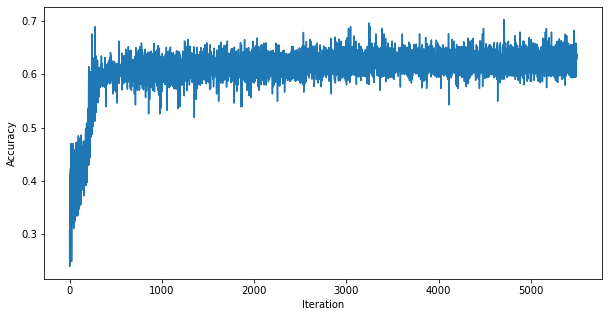

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

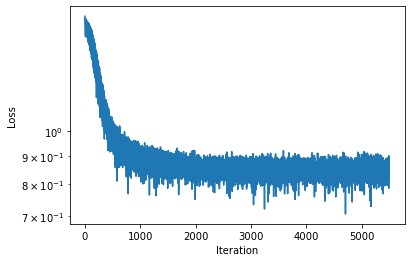

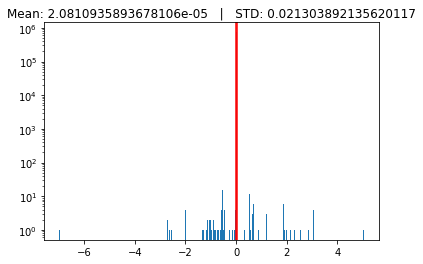

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 9.977777777777778


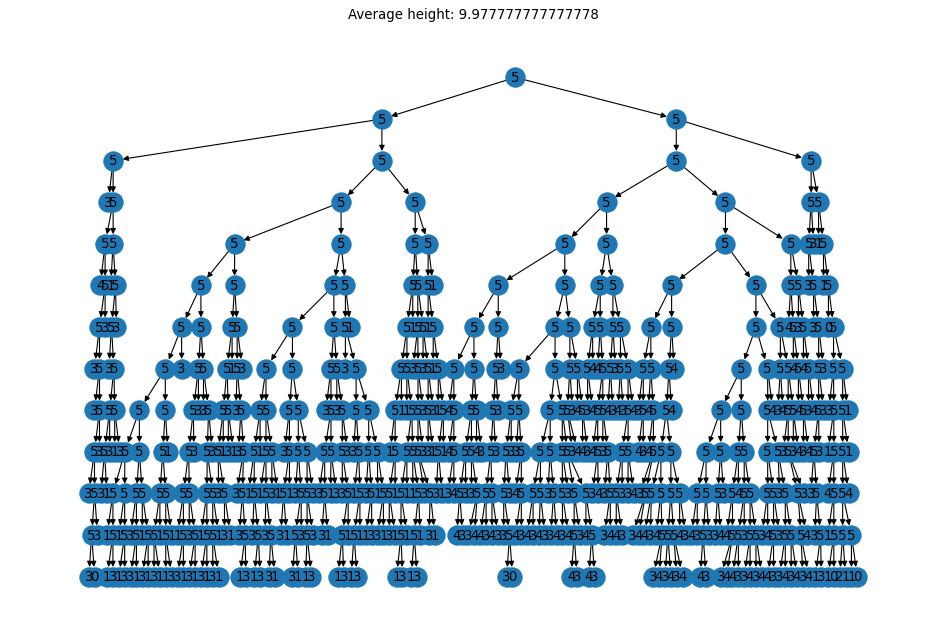

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 315


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
5096
============== Pattern 2 ==============
665
============== Pattern 3 ==============
1150
============== Pattern 4 ==============
861
============== Pattern 5 ==============
1559
============== Pattern 6 ==============
============== Pattern 7 ==============
217
============== Pattern 8 ==============
956
============== Pattern 9 ==============
1368
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ====

============== Pattern 217 ==============
============== Pattern 218 ==============
============== Pattern 219 ==============
============== Pattern 220 ==============
============== Pattern 221 ==============
============== Pattern 222 ==============
============== Pattern 223 ==============
============== Pattern 224 ==============
============== Pattern 225 ==============
============== Pattern 226 ==============
============== Pattern 227 ==============
============== Pattern 228 ==============
============== Pattern 229 ==============
============== Pattern 230 ==============
============== Pattern 231 ==============
============== Pattern 232 ==============
============== Pattern 233 ==============
============== Pattern 234 ==============
============== Pattern 235 ==============
============== Pattern 236 ==============
============== Pattern 237 ==============
============== Pattern 238 ==============
============== Pattern 239 ==============
============== Pattern 240 =======